In [2]:
import sys,os,os.path

sys.path.append("../")   # cite IC from parent directory
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


# HIGH PRESSURE LAB BOOK

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#adding here ROI
emin = 1.5
emax = 1.7

In [5]:
# list of all files in a folder
folder_path = 'HPR/208Tl/PORT_1a/prod/isaura/isaura_chunk/'
#file = f'isaura/isaura_10_228Th.h5'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# NOTE Break this section up, its annoying like this.
dfs = []
df_trs = []
df_ems = []
i = 0
end = len(file_names)
# create massive dataframe with all of them
for file in file_names:
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)
    # include MC particles (boooo takes ages)

    # collecting the correct components of the file, not exactly sure how this works
    df_ps = pd.read_hdf(file_path, 'MC/particles')
    #df_ps = df_ps[df_ps.creator_proc == 'conv']
    # collecting event map
    df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
    df_trs.append(df_ps)
    df_ems.append(df_em)
    i += 1

    if (i%1000 == 0):
        print(i)

tracks = pd.concat(dfs, axis=0, ignore_index=True)

particles = pd.concat(df_trs, ignore_index=True)
eventmap = pd.concat([dt for dt in df_ems])
# create particle list also


In [6]:
test_df = pd.read_hdf(f'HPR/208Tl/PORT_1a/prod/isaura/isaura_chunk/isaura_10_208Tl.h5', 'MC/particles')
display(test_df)
test_df_2 = pd.read_hdf(f'HPR/208Tl/PORT_1a/prod/isaura/isaura_chunk/isaura_11_208Tl.h5', 'MC/particles')
display(test_df_2)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,180000,1,Tl208,True,0,392.884155,396.773743,533.074219,0.000000,392.884155,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,180000,4,e-,False,1,392.884155,396.773743,533.074219,0.000145,406.875000,...,-0.245986,-0.030848,-0.141277,0.00000,0.00000,-0.000000,0.074270,29.544952,RadioactiveDecay,eIoni
2,180000,5,e-,False,4,405.034332,405.087769,535.513855,0.161412,405.060852,...,0.009434,0.031665,-0.019595,-0.00000,-0.00000,0.000000,0.001442,0.095609,eIoni,eIoni
3,180000,3,anti_nu_e,False,1,392.884155,396.773743,533.074219,0.000145,8388.099609,...,0.909860,-1.467660,-0.016891,0.90986,-1.46766,-0.016891,1.726892,15174.724609,RadioactiveDecay,Transportation
4,180000,2,Pb208[3197.711],False,1,392.884155,396.773743,533.074219,0.000145,392.884155,...,-0.663873,1.498506,0.158168,-0.00000,0.00000,0.000000,0.000007,0.000000,RadioactiveDecay,RadioactiveDecay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147367,181819,109,e-,False,107,222.131668,461.153137,313.065826,1.197254,222.131668,...,-0.028683,0.010765,0.004614,-0.00000,-0.00000,0.000000,0.000938,0.000016,compt,eIoni
147368,181819,108,e-,False,107,222.131668,461.153137,313.065826,1.197254,222.129608,...,-0.190941,-0.132324,-0.088707,-0.00000,-0.00000,0.000000,0.057294,0.010096,compt,eIoni
147369,181819,84,e-,False,82,389.657013,396.028534,522.755676,0.050406,389.657013,...,-0.019640,-0.019104,-0.014473,-0.00000,-0.00000,0.000000,0.000939,0.000017,compt,eIoni
147370,181819,83,e-,False,82,389.657013,396.028534,522.755676,0.050406,389.688629,...,-0.397983,-0.728149,-0.707834,-0.00000,0.00000,0.000000,0.693468,0.268024,compt,eIoni


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,200000,1,Tl208,True,0,397.064331,398.560059,530.965027,0.000000,397.064331,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,none,RadioactiveDecay
1,200000,4,e-,False,1,397.064331,398.560059,530.965027,0.000133,396.733002,...,-0.583997,0.966223,-0.809618,0.000000,-0.000000,0.00000,0.969285,1.562224,RadioactiveDecay,eIoni
2,200000,3,anti_nu_e,False,1,397.064331,398.560059,530.965027,0.000133,12500.000000,...,0.546213,0.090742,0.030020,0.546213,0.090742,0.03002,0.554512,12286.833984,RadioactiveDecay,Transportation
3,200000,2,Pb208[3475.078],False,1,397.064331,398.560059,530.965027,0.000133,397.064331,...,0.037784,-1.056966,0.779598,0.000000,-0.000000,0.00000,0.000004,0.000000,RadioactiveDecay,RadioactiveDecay
4,200000,6,gamma,False,2,397.064331,398.560059,530.965027,0.000133,303.429474,...,-0.160178,-0.041061,0.222686,-0.000000,-0.000000,0.00000,0.277367,162.139328,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152091,201879,110,e-,False,108,322.944458,158.397003,455.238068,1.446907,322.946564,...,0.041762,0.029115,0.020065,0.000000,-0.000000,0.00000,0.002922,0.012692,phot,eIoni
152092,201879,109,e-,False,108,322.944458,158.397003,455.238068,1.446907,322.944824,...,0.029786,-0.012434,-0.013883,0.000000,0.000000,-0.00000,0.001207,0.002894,phot,eIoni
152093,201879,107,e-,False,68,310.223846,174.600525,458.782288,1.336588,310.292938,...,0.156262,0.157451,0.059096,-0.000000,-0.000000,-0.00000,0.049198,1.143716,eIoni,eIoni
152094,201879,106,e-,False,68,264.349915,168.192871,486.677216,1.076797,265.191772,...,0.378524,-0.058576,-0.191093,-0.000000,0.000000,0.00000,0.155595,6.631486,eIoni,eIoni


In [7]:
#display(particles)
#display(eventmap)

So from the event map above, the evt_number category is always double the nexus event value (weird but okay)
evt_number corresponds to tracks ``event``, while nexus_evt corresponds to particles ``event_id``

Really rogue idea, lets just double the values of event_id...


In [8]:
# double check that this is a valid solution

eventmap_reset = eventmap.reset_index()
display(eventmap_reset)

if not (eventmap_reset['nexus_evt'] * 2 == eventmap_reset['evt_number']).all():
    print("Falses in here!")
else:
    print("No Falses to be seen!")

# So it really is double!

,nexus_evt,evt_number
0,1740000,3480000
1,1740001,3480002
2,1740002,3480004
3,1740003,3480006
4,1740004,3480008
...,...,...
185130,1761875,3523750
185131,1761876,3523752
185132,1761877,3523754
185133,1761878,3523756


No Falses to be seen!


In [9]:
particles['event_id'] = particles['event_id'] * 2 
display(particles)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,3480000,1,Tl208,True,0,395.310089,395.704559,535.993408,0.000000,395.310089,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,3480000,4,e-,False,1,395.310089,395.704559,535.993408,0.000235,393.921204,...,-0.555673,0.848747,0.540154,0.000000,-0.000000,0.000000,0.746789,3.146374,RadioactiveDecay,eIoni
2,3480000,3,anti_nu_e,False,1,395.310089,395.704559,535.993408,0.000235,12500.000000,...,0.400432,-0.182635,0.319123,0.400432,-0.182635,0.319123,0.543637,16433.644531,RadioactiveDecay,Transportation
3,3480000,2,Pb208[3708.451],False,1,395.310089,395.704559,535.993408,0.000235,395.310089,...,0.155241,-0.666112,-0.859276,0.000000,-0.000000,-0.000000,0.000003,0.000000,RadioactiveDecay,RadioactiveDecay
4,3480000,6,gamma,False,2,395.310089,395.704559,535.993408,0.000235,409.662811,...,0.194574,0.370955,-0.292213,0.000000,-0.000000,0.000000,0.510739,50.666115,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15255173,3523758,66,e-,False,61,381.456512,-282.986877,719.079102,3.755936,381.457672,...,0.027642,-0.042814,0.018238,0.000000,-0.000000,0.000000,0.002859,0.010377,phot,eIoni
15255174,3523758,65,e-,False,61,381.456512,-282.986877,719.079102,3.755936,381.514496,...,0.110042,0.089824,-0.104747,0.000000,0.000000,0.000000,0.029621,0.440189,phot,eIoni
15255175,3523758,60,e-,False,29,378.876312,-283.276764,721.195679,3.744762,385.492767,...,0.239401,-0.503358,0.374395,0.000000,0.000000,0.000000,0.332786,23.957703,phot,eIoni
15255176,3523758,59,e-,False,29,-8.097856,154.905426,511.731750,1.673364,-8.135881,...,-0.118088,0.011900,0.186761,-0.000000,-0.000000,-0.000000,0.045855,0.833333,compt,eIoni


##### Loading file

Lets try and load the magical file in, usually I'd use h5py but not here because IC doesn't.

The different outputs can be read about [here](https://next-exp-sw.readthedocs.io/en/latest/isaura.html).

In [10]:
#tracks = dstio.load_dst(file, 'Tracking', 'Tracks')
#evts = dstio.load_dst(file, 'Summary', 'Events')
#pen_out = dstio.load_dst(file, 'DST', 'Events')
#hit_flag = dstio.load_dst(file, 'Filters', 'hits_select')
#top_flag = dstio.load_dst(file, 'Filters', 'topology_select')
print(len(tracks))

415438


In [11]:
display(tracks)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,3480000,0,0.343447,21.699787,17,2786,1,-287.325,356.675,409.538513,...,411.791374,-274.646777,375.757093,425.823266,0.343216,0.341263,0.341032,7.666667,8.000000,4.810127
1,3480002,0,0.305225,14.284631,7,1924,2,144.675,399.675,438.081512,...,444.779671,156.915253,411.681642,441.289557,0.305225,0.305225,0.305225,9.400000,9.571429,4.906980
2,3480002,1,0.193640,14.284631,8,1548,2,210.675,284.675,585.917908,...,587.945685,222.717048,296.608574,591.816074,0.193640,0.193640,0.193640,9.400000,9.571429,4.906980
3,3480004,0,1.598826,91.058895,69,6739,3,217.675,221.675,98.730064,...,155.599227,249.513361,223.451029,104.292833,0.836897,0.302969,0.000000,9.529412,9.909091,4.996318
4,3480004,1,0.166581,13.747719,4,965,3,360.675,215.675,588.426636,...,590.956474,371.630599,217.368350,591.819895,0.166581,0.166512,0.166512,9.529412,9.909091,4.996318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415433,3523756,0,0.307280,24.306547,14,2731,2,327.675,332.675,646.363586,...,657.741088,346.531874,339.576027,651.502046,0.307244,0.307102,0.307066,9.636364,9.952381,4.827515
415434,3523756,1,0.144041,14.670184,5,794,2,412.675,154.675,689.198547,...,691.045916,425.142575,160.348057,694.993776,0.144041,0.144041,0.144041,9.636364,9.952381,4.827515
415435,3523758,0,1.867777,90.991887,75,5932,3,-28.325,133.675,478.399475,...,480.843515,19.659085,203.809971,504.800833,0.526968,0.098849,0.000000,9.947368,9.942308,4.972880
415436,3523758,1,0.105139,11.121136,4,1404,3,374.675,-288.325,722.822327,...,724.344832,386.874508,-282.313050,728.826303,0.105139,0.105139,0.105139,9.947368,9.942308,4.972880


In [12]:
#evts.head()

In [13]:
#pen_out.head()

In [14]:
#hit_flag.head()

In [15]:
#top_flag.head()

##### So I'm pretty sure we care about the tracks rather than the rest of the stuff, lets look at it and compare to beersheba.

In [16]:
tracks.head(20)
# so you can see here that the events with one track are
# 360000, 360002, 360012, etc

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,3480000,0,0.343447,21.699787,17,2786,1,-287.325,356.675,409.538513,...,411.791374,-274.646777,375.757093,425.823266,0.343216,0.341263,0.341032,7.666667,8.000000,4.810127
1,3480002,0,0.305225,14.284631,7,1924,2,144.675,399.675,438.081512,...,444.779671,156.915253,411.681642,441.289557,0.305225,0.305225,0.305225,9.400000,9.571429,4.906980
2,3480002,1,0.193640,14.284631,8,1548,2,210.675,284.675,585.917908,...,587.945685,222.717048,296.608574,591.816074,0.193640,0.193640,0.193640,9.400000,9.571429,4.906980
3,3480004,0,1.598826,91.058895,69,6739,3,217.675,221.675,98.730064,...,155.599227,249.513361,223.451029,104.292833,0.836897,0.302969,0.000000,9.529412,9.909091,4.996318
4,3480004,1,0.166581,13.747719,4,965,3,360.675,215.675,588.426636,...,590.956474,371.630599,217.368350,591.819895,0.166581,0.166512,0.166512,9.529412,9.909091,4.996318
5,3480004,2,0.113769,23.656810,9,1004,3,270.675,165.675,770.706055,...,774.954692,287.398867,171.539637,776.279594,0.110941,0.109510,0.106682,9.529412,9.909091,4.996318
6,3480006,0,0.465922,19.277356,11,2807,3,-168.325,199.675,805.160828,...,808.607208,-155.666476,211.416417,816.315945,0.465922,0.465922,0.465922,10.000000,9.000000,4.944051
7,3480006,1,0.350962,18.000000,8,1856,3,52.675,172.675,730.391174,...,737.296268,59.268501,191.601948,738.754662,0.350962,0.350962,0.350962,10.000000,9.000000,4.944051
8,3480006,2,0.000302,0.000000,1,10,3,-178.325,241.675,808.503723,...,808.503723,-177.020492,242.977976,808.503723,0.000302,0.000302,0.000302,10.000000,9.000000,4.944051
9,3480008,0,0.370282,20.149433,9,2115,2,192.675,25.675,685.876953,...,693.211417,206.482439,32.551440,688.974559,0.370282,0.370264,0.370264,9.777778,9.466667,4.950122


In [17]:
# select a specific event
n = 2
evnt = tracks.event.unique()[n]
print("Event of interest: {}".format(evnt))

trk = tracks[tracks.event==evnt]
trk.head()

Event of interest: 3480004


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3,3480004,0,1.598826,91.058895,69,6739,3,217.675,221.675,98.730064,...,155.599227,249.513361,223.451029,104.292833,0.836897,0.302969,0.000000,9.529412,9.909091,4.996318
4,3480004,1,0.166581,13.747719,4,965,3,360.675,215.675,588.426636,...,590.956474,371.630599,217.368350,591.819895,0.166581,0.166512,0.166512,9.529412,9.909091,4.996318
5,3480004,2,0.113769,23.656810,9,1004,3,270.675,165.675,770.706055,...,774.954692,287.398867,171.539637,776.279594,0.110941,0.109510,0.106682,9.529412,9.909091,4.996318


In [18]:
# look at all the columns
col_titles = tracks.columns.tolist()
clean_output = "\n".join(col_titles)
print(clean_output)

event
trackID
energy
length
numb_of_voxels
numb_of_hits
numb_of_tracks
x_min
y_min
z_min
r_min
x_max
y_max
z_max
r_max
x_ave
y_ave
z_ave
r_ave
extreme1_x
extreme1_y
extreme1_z
extreme2_x
extreme2_y
extreme2_z
blob1_x
blob1_y
blob1_z
blob2_x
blob2_y
blob2_z
eblob1
eblob2
ovlp_blob_energy
vox_size_x
vox_size_y
vox_size_z


##### Cuts

We want to:
- Include events within the fiducial volume [r < 472mm; 20 mm < z < 1195mm]
- only include 1-track events
- No overlapping blobs
- Energy cut for thallium [1.5, 1.7] MeV

In [19]:
def cut_effic(df1, df2, verbose = False):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    print("Efficiency: {:.2f} %".format(efficiency))

    if (verbose == True):
        print(("Events in reduced dataframe: {}\nEvents in initial dataframe: {}").format(len(df1), len(df2)))

    return efficiency


In [20]:
def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (MeV)', range = 0, data = False):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, range = range)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return

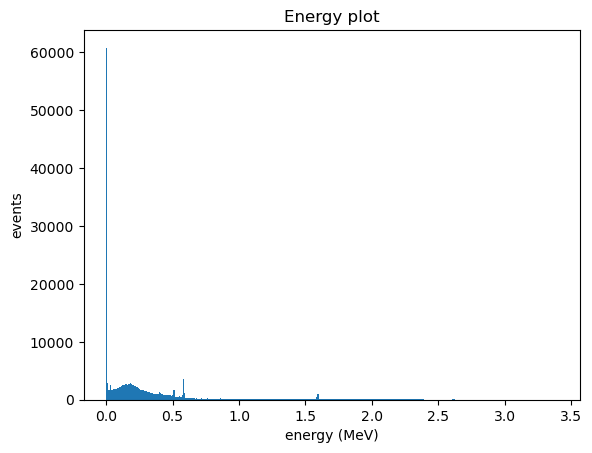

In [21]:
# plot the energy
plot_hist(tracks, binning = 1000)

In [22]:
# testing gth_lth_cuts logic
display(tracks.head())
# we'll remove event 360004 trackID 1 by applying cut < 22mm for xmin
display((tracks[(abs(tracks['x_min']) >= 22)]).head())
print("Are arrays the same length with this cut applied?")
print(len((tracks[(abs(tracks['x_min']) >= 22)])) == len(tracks))
print("How about with a 0 cut?")
print(len((tracks[(abs(tracks['x_min']) >= 0)])) == len(tracks))
print("Checks out")

# but we care about radius, need to check if radius is ever negative.
print((tracks['r_max'] <= 0))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,3480000,0,0.343447,21.699787,17,2786,1,-287.325,356.675,409.538513,...,411.791374,-274.646777,375.757093,425.823266,0.343216,0.341263,0.341032,7.666667,8.000000,4.810127
1,3480002,0,0.305225,14.284631,7,1924,2,144.675,399.675,438.081512,...,444.779671,156.915253,411.681642,441.289557,0.305225,0.305225,0.305225,9.400000,9.571429,4.906980
2,3480002,1,0.193640,14.284631,8,1548,2,210.675,284.675,585.917908,...,587.945685,222.717048,296.608574,591.816074,0.193640,0.193640,0.193640,9.400000,9.571429,4.906980
3,3480004,0,1.598826,91.058895,69,6739,3,217.675,221.675,98.730064,...,155.599227,249.513361,223.451029,104.292833,0.836897,0.302969,0.000000,9.529412,9.909091,4.996318
4,3480004,1,0.166581,13.747719,4,965,3,360.675,215.675,588.426636,...,590.956474,371.630599,217.368350,591.819895,0.166581,0.166512,0.166512,9.529412,9.909091,4.996318


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,3480000,0,0.343447,21.699787,17,2786,1,-287.325,356.675,409.538513,...,411.791374,-274.646777,375.757093,425.823266,0.343216,0.341263,0.341032,7.666667,8.000000,4.810127
1,3480002,0,0.305225,14.284631,7,1924,2,144.675,399.675,438.081512,...,444.779671,156.915253,411.681642,441.289557,0.305225,0.305225,0.305225,9.400000,9.571429,4.906980
2,3480002,1,0.193640,14.284631,8,1548,2,210.675,284.675,585.917908,...,587.945685,222.717048,296.608574,591.816074,0.193640,0.193640,0.193640,9.400000,9.571429,4.906980
3,3480004,0,1.598826,91.058895,69,6739,3,217.675,221.675,98.730064,...,155.599227,249.513361,223.451029,104.292833,0.836897,0.302969,0.000000,9.529412,9.909091,4.996318
4,3480004,1,0.166581,13.747719,4,965,3,360.675,215.675,588.426636,...,590.956474,371.630599,217.368350,591.819895,0.166581,0.166512,0.166512,9.529412,9.909091,4.996318


Are arrays the same length with this cut applied?
False
How about with a 0 cut?
True
Checks out
0         False
1         False
2         False
3         False
4         False
          ...  
415433    False
415434    False
415435    False
415436    False
415437    False
Name: r_max, Length: 415438, dtype: bool


In [23]:
'''def gth_lth_cuts(df, column_title, one_sided = False, lower_lim = 0, upper_lim = 0, absolute = True):
    #applies cut on column via upper and lower limits (greater than, lesser than)
    #column title for two sided should be a tuple!

    # double sided
    if (one_sided==False):
        # conditional absolute for fiducial case, so include negative values within this range.
        if (absolute == True):
            filt_df = df[(abs(df[column_title[0]]) >= lower_lim) & (abs(df[column_title[1]]) <= upper_lim)]
        else:
            filt_df = df[(df[column_title[0]] >= lower_lim) & (df[column_title[1]] <= upper_lim)]
    # one sided (lower or upper limit)
    else:
        # set greater or lesser based on lower or upper limit being 0
        print("placeholder")
'''
'''
def fiducial_track_cut(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    
    # Bespoke cutting algorithm for NEXT100 isaura which cuts for fiducial volume
    # z is contrained in a two-sided fashion (greater and less than), while R is taken not treated is one-sided.
    
    # create list of events that are outside the fiducial area
    z_df = df[(df['z_min'] <= lower_z) & (df['z_max'] >= upper_z)]
    rz_df = z_df[(z_df['r_max'] >= r_lim)]
    print(rz_df['event'])


    # z filtering
    filt_z_df = df[(df['z_min'] >= lower_z) & (df['z_max'] <= upper_z)] # mm

    # r filtering
    filt_df = filt_z_df[(filt_z_df['r_max'] <= r_lim)]

    # these two create masks, then you need to collect the events to preserve based on this.

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))

    return filt_df
'''


def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Produces fiducial track cuts while removing all events that have outer fiducial tracks
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low['event'].to_numpy())
    up_list = (z_df_up['event'].to_numpy())
    r_list = (r_df['event'].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df['event'].isin(low_list)]
    df2 = df1[~df1['event'].isin(up_list)]
    df3 = df2[~df2['event'].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3



In [24]:
def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    THERE IS A COLUMN WITH THIS INFO IN IT, CALCULATING IT IS UNNECESSARY
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events

In [25]:
def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove
    

In [26]:
def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df


In [27]:
def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1


##### Now lets look at the fiducial selection parameters to get a feeling of whats going on

In [28]:
def plot_volume_hists(df):

    plot_hist(df, column = 'x_min', output = False, label = 'x_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'x_max', title = 'x plot for full volume', output = False, label = 'x_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'y_min', output = False, label = 'y_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'y_max', title = 'y plot for full volume', output = False, label = 'y_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'z_min', output = False, label = 'z_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'z_max', title = 'z plot for full volume', output = False, label = 'z_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

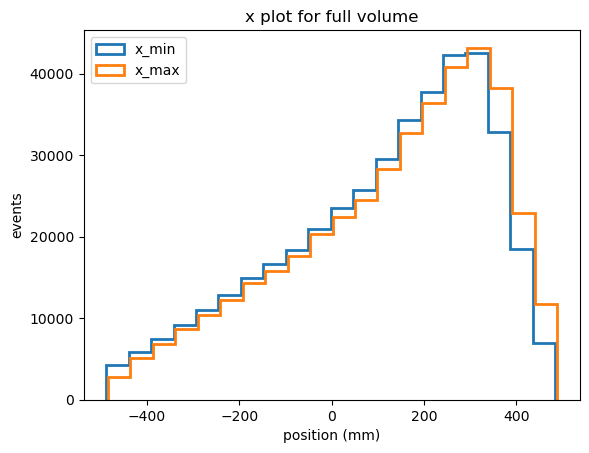

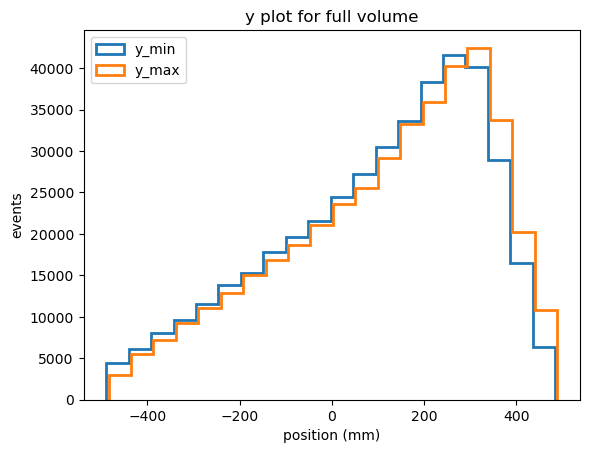

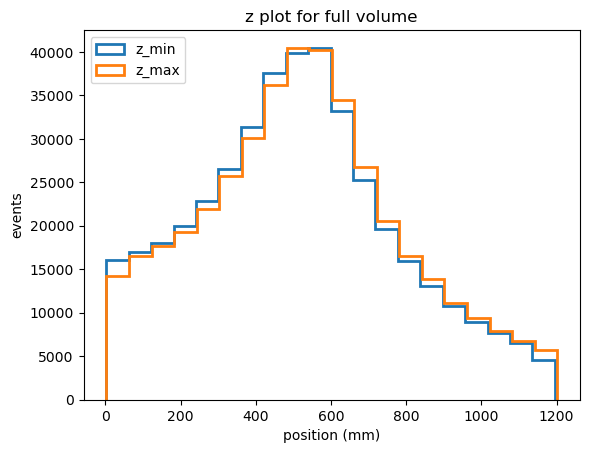

In [29]:
plot_volume_hists(tracks)

##### Considering the fiducial limits, this looks okay?
Limits:
- 20mmm < z < 1195mm
- r < 472mm (x and y limits in the -ve and negative)

Although the 472 radius seems really generous, maybe that cut has already been made? lets do a test


In [30]:
# checking what the largest x position is
x_max_max = tracks['x_max'].max()
print("Largest x_max values: {:.2f}".format(x_max_max))

Largest x_max values: 488.68


##### So this is outside the fiducial volume, this seems okay. Looking at when binning is changed from 20 -> 50, saw only artifacts in the z section.

##### So now to apply fiducial cuts

In [31]:
# for easy tracking
cut_names = []
rel_cut_effics = []
abs_cut_effics = []
cut_events = []

# no cuts
cut_names.append("No cuts")
rel_cut_effics.append(100)
abs_cut_effics.append(100)
# number of events
cut_events.append(len_events(tracks))

cut_names.append("Fiducial Cuts")

# make fiducial cuts
fiducial = fiducial_track_cut_2(tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = True)

# make efficiency calculation
ef = cut_effic(fiducial, tracks)

# add efficiency calculation
rel_cut_effics.append(ef)
cut_events.append(len_events(fiducial))
abs_cut_effics.append(ef)

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Efficiency: 72.26 %


##### And the one track cut

In [32]:
# relative

cut_names.append("One track cut")
one_track_rel = one_track_cuts(fiducial, verbose = True)

# events are relative, as absolute efficiency lets you figure out events from the beginning# absolute
one_track_abs = one_track_cuts(tracks)

## sanity check here
#print(len_events(one_track_rel), len_events(one_track_abs), len_events(tracks))

# relative
print("Single track cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(one_track_rel, fiducial)
rel_cut_effics.append(ef)
cut_events.append(len_events(one_track_rel))

# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(one_track_abs, tracks)
abs_cut_effics.append(ef)

Removing events with more than one track.
Events with one track: Int64Index([     22,      28,      32,      46,      58,      72,      80,
                 82,      86,      88,
            ...
            3963718, 3963750, 3963752, 3963780, 3963782, 3963784, 3963786,
            3963792, 3963822, 3963824],
           dtype='int64', name='event', length=44524)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,3480000,0,0.343447,21.699787,17,2786,1,-287.325,356.675,409.538513,...,411.791374,-274.646777,375.757093,425.823266,0.343216,0.341263,0.341032,7.666667,8.000000,4.810127
12,3480012,0,0.419707,21.288917,14,2348,1,208.675,328.675,591.799072,...,593.394164,217.507985,349.192612,601.384420,0.419383,0.418772,0.418448,8.666667,9.666667,4.456462
18,3480018,0,0.484111,17.684702,14,2502,1,-81.325,300.675,763.994141,...,769.296368,-62.878384,310.143453,776.965639,0.484111,0.484111,0.484111,8.000000,8.000000,3.766586
25,3480026,0,0.403008,19.495693,15,2458,1,207.675,163.675,633.799805,...,643.629225,220.652277,167.700295,635.796017,0.403008,0.402757,0.402757,7.666667,8.666667,4.461995
54,3480050,0,0.585978,23.136976,16,3109,1,-63.325,140.675,504.453339,...,511.095818,-57.011982,149.977081,507.543910,0.585384,0.584850,0.584255,9.333333,9.000000,4.735972


Single track cut
Relative Cut efficiency:
Efficiency: 33.28 %
Absolute Cut efficiency:
Efficiency: 30.01 %


#### Plot the spacial stuff and compare

Looks good to me

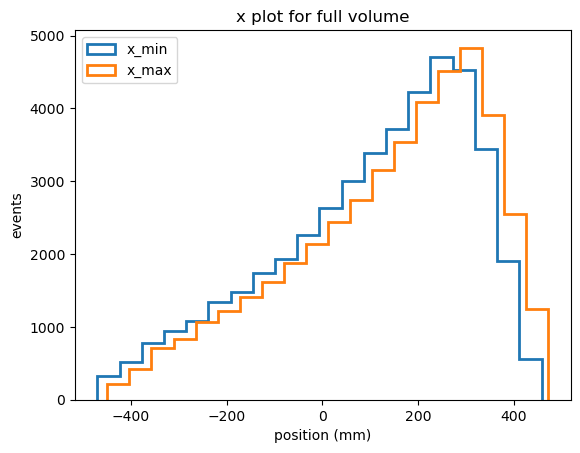

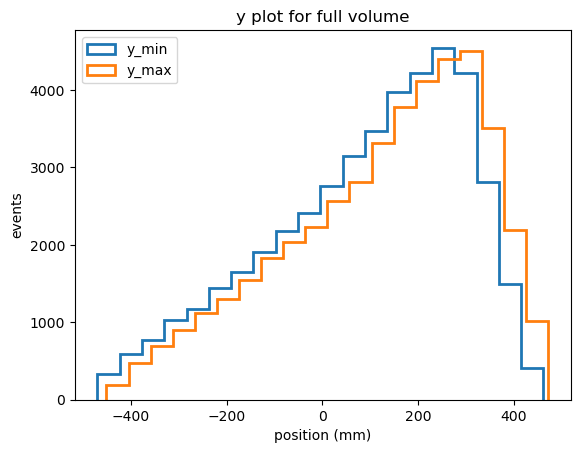

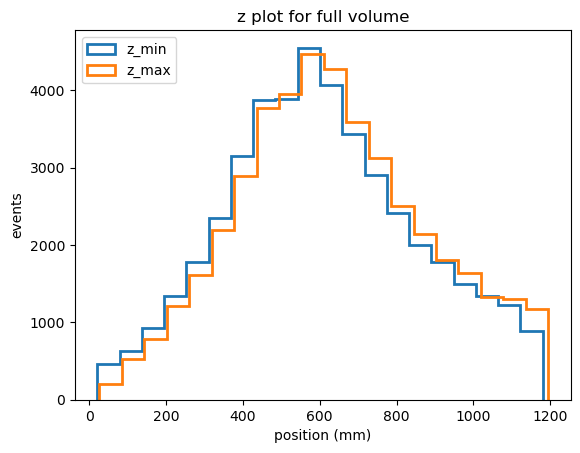

In [33]:
plot_volume_hists(one_track_rel)

#### No overlapping blobs

I have to assume this is achieved by setting ovlp_blob_energy, but lets look at these values and see if thats easy.

In [34]:
display(one_track_rel['ovlp_blob_energy'])


0         0.341032
12        0.418448
18        0.484111
25        0.402757
54        0.584255
            ...   
415398    0.551275
415399    0.000000
415419    0.000000
415426    0.404488
415429    0.491607
Name: ovlp_blob_energy, Length: 44524, dtype: float64

Seems to have a lot of values at zero, so I think this is an acceptable cut method

In [35]:
# apply cuts
ovlp_rel = overlapping_cuts(one_track_rel)
ovlp_abs = overlapping_cuts(tracks)

In [36]:
cut_names.append("Blob overlap cuts")


# relative
print("Blob overlap cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ovlp_rel, one_track_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ovlp_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ovlp_rel, tracks)
abs_cut_effics.append(ef)

Blob overlap cut
Relative Cut efficiency:
Efficiency: 35.60 %
Absolute Cut efficiency:
Efficiency: 8.56 %


#### Energy cut

Want to limit range from [1.5, 1.7] MeV

In [37]:
ecut_rel = energy_cuts(ovlp_rel)
ecut_abs = energy_cuts(tracks)

cut_names.append("Energy cuts")

# relative
print("Energy cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ecut_rel, ovlp_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ecut_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ecut_rel, tracks)
abs_cut_effics.append(ef)

Energy cut
Relative Cut efficiency:
Efficiency: 21.08 %
Absolute Cut efficiency:
Efficiency: 1.81 %


#### Print cut efficiency relative and absolute as a table and plot the energy of the final cuts

In [38]:
efficiencies = pd.DataFrame({'Cut': cut_names,
                             'Relative Efficiency': rel_cut_effics,
                             'Single Cut Efficiency': abs_cut_effics,
                             'Relative Events': cut_events})

In [39]:
display(efficiencies)
# NOTE!!! THE EVENTS ARE RELATIVE. So to get the number of events by single cut,
# multiply the events against single cut efficiency

,Cut,Relative Efficiency,Single Cut Efficiency,Relative Events
0,No cuts,100.000000,100.000000,185135
1,Fiducial Cuts,72.262943,72.262943,133784
2,One track cut,33.280512,30.008912,44524
3,Blob overlap cuts,35.601024,8.561860,15851
4,Energy cuts,21.083843,1.805169,3342


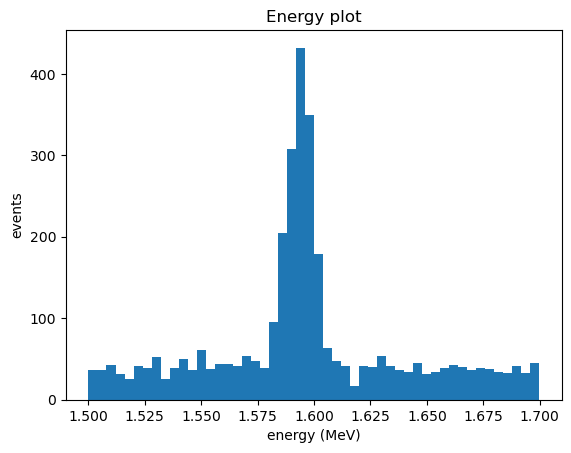

In [40]:
# plot energy of final
plot_hist(ecut_rel, binning = 50)

#### Histogram plotting showing the effect of all the cuts:

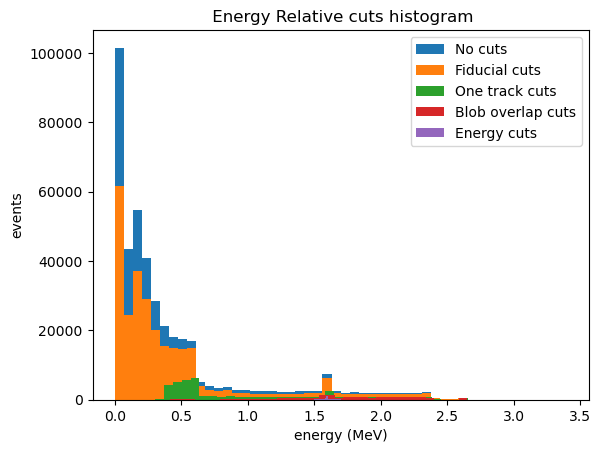

In [41]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(fiducial, label = 'Fiducial cuts', output = False, binning = 50)
plot_hist(one_track_rel, label = 'One track cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'Blob overlap cuts', output = False, binning = 50)
plot_hist(ecut_rel, label = 'Energy cuts', output = False, title=' Energy Relative cuts histogram')
plt.legend()
plt.show()

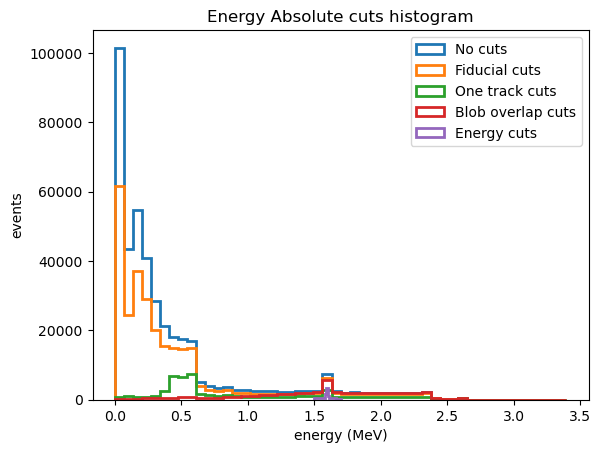

In [42]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50, fill = False)
plot_hist(fiducial, label = 'Fiducial cuts', output = False, binning = 50, fill = False)
plot_hist(one_track_abs, label = 'One track cuts', output = False, binning = 50, fill = False)
plot_hist(ovlp_abs, label = 'Blob overlap cuts', output = False, binning = 50, fill = False)
plot_hist(ecut_abs, label = 'Energy cuts', output = False, title='Energy Absolute cuts histogram', fill = False)
plt.legend()
plt.show()

##### Lets do the same but exclude the final energy cut and log it

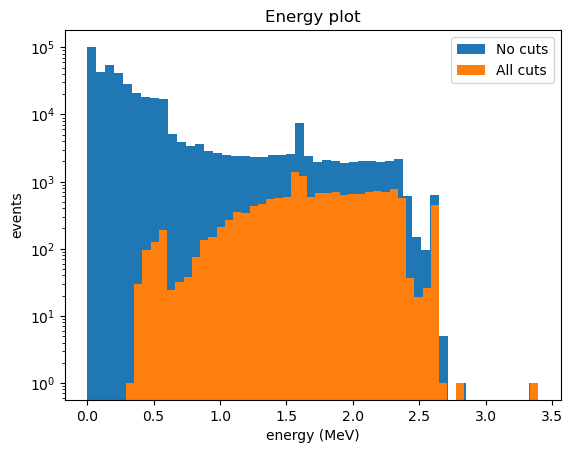

In [43]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'All cuts', output = False, binning = 50)
plt.yscale('log')
plt.legend()
plt.show()

0.013388172848481563 1.5186213901609222


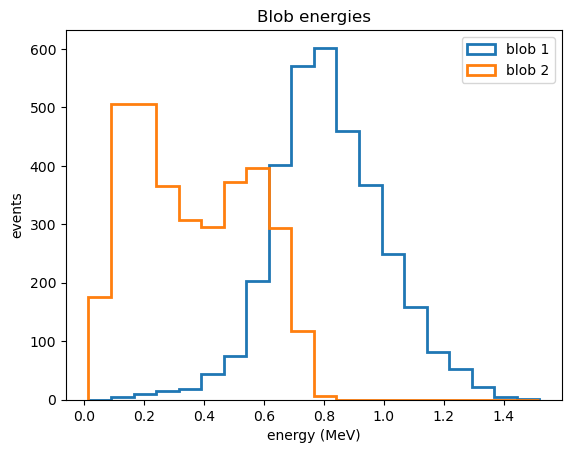

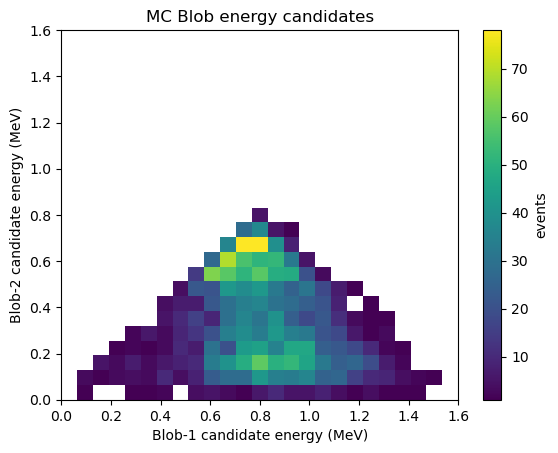

In [44]:
# produce nicer plots, this is energy histograms for the blobs post-all cuts

# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(ecut_rel['eblob1'].to_numpy())
eblob_full.append(ecut_rel['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)
print(minimum_e, maximum_e)

plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plt.legend()
plt.show()

# blob 2dhist
plt.hist2d(ecut_rel['eblob1'], ecut_rel['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates")
plt.show()

In [45]:
display(ecut_rel)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
62,3480056,0,1.589351,60.063916,55,7316,1,-252.325,168.675,508.630432,...,515.157082,-246.912353,175.661834,542.387824,0.796147,0.490546,0.0,10.000000,9.000000,4.717968
71,3480062,0,1.610236,54.719562,67,7067,1,148.675,353.675,626.234802,...,628.872816,192.835279,367.553134,643.313069,0.986405,0.464227,0.0,8.500000,9.800000,4.190847
260,3480234,0,1.668941,95.578538,91,6606,1,29.675,99.675,958.878662,...,996.187132,37.798999,106.568182,976.734142,0.926269,0.226842,0.0,8.714286,9.375000,4.928574
449,3480398,0,1.642469,74.207940,78,7635,1,125.675,359.675,412.038788,...,454.023821,132.102884,389.754106,415.829920,0.965561,0.195324,0.0,9.400000,9.000000,4.948486
483,3480432,0,1.581915,100.186284,64,6766,1,305.675,-245.325,381.815491,...,388.863272,338.509008,-155.771243,399.056458,0.825521,0.405142,0.0,8.800000,9.800000,4.687659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415050,3523416,0,1.563435,97.362939,86,6953,1,175.675,156.675,767.335205,...,825.438098,220.794684,170.303289,773.725019,0.692239,0.173943,0.0,8.500000,8.800000,4.755790
415055,3523422,0,1.694754,58.037745,67,7046,1,104.675,241.675,842.952148,...,878.158418,143.637739,264.920154,845.148360,1.021903,0.445297,0.0,8.500000,9.666667,4.926918
415153,3523506,0,1.549871,78.523025,75,6434,1,119.675,169.675,737.110779,...,740.165462,154.070310,211.088016,789.386852,0.869042,0.237426,0.0,9.200000,9.200000,4.961437
415234,3523574,0,1.637544,83.518996,99,6540,1,177.675,276.675,406.176331,...,422.642931,200.569211,303.288494,468.754185,0.945560,0.159757,0.0,9.166667,8.250000,4.674641


#### Playing around with MC

Want to make a plot that shows the MC background here

In [46]:
# MC stuff taken from above
display(particles)
#display(eventmap.head(5))
display(ecut_rel.head())


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,3480000,1,Tl208,True,0,395.310089,395.704559,535.993408,0.000000,395.310089,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,3480000,4,e-,False,1,395.310089,395.704559,535.993408,0.000235,393.921204,...,-0.555673,0.848747,0.540154,0.000000,-0.000000,0.000000,0.746789,3.146374,RadioactiveDecay,eIoni
2,3480000,3,anti_nu_e,False,1,395.310089,395.704559,535.993408,0.000235,12500.000000,...,0.400432,-0.182635,0.319123,0.400432,-0.182635,0.319123,0.543637,16433.644531,RadioactiveDecay,Transportation
3,3480000,2,Pb208[3708.451],False,1,395.310089,395.704559,535.993408,0.000235,395.310089,...,0.155241,-0.666112,-0.859276,0.000000,-0.000000,-0.000000,0.000003,0.000000,RadioactiveDecay,RadioactiveDecay
4,3480000,6,gamma,False,2,395.310089,395.704559,535.993408,0.000235,409.662811,...,0.194574,0.370955,-0.292213,0.000000,-0.000000,0.000000,0.510739,50.666115,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15255173,3523758,66,e-,False,61,381.456512,-282.986877,719.079102,3.755936,381.457672,...,0.027642,-0.042814,0.018238,0.000000,-0.000000,0.000000,0.002859,0.010377,phot,eIoni
15255174,3523758,65,e-,False,61,381.456512,-282.986877,719.079102,3.755936,381.514496,...,0.110042,0.089824,-0.104747,0.000000,0.000000,0.000000,0.029621,0.440189,phot,eIoni
15255175,3523758,60,e-,False,29,378.876312,-283.276764,721.195679,3.744762,385.492767,...,0.239401,-0.503358,0.374395,0.000000,0.000000,0.000000,0.332786,23.957703,phot,eIoni
15255176,3523758,59,e-,False,29,-8.097856,154.905426,511.731750,1.673364,-8.135881,...,-0.118088,0.011900,0.186761,-0.000000,-0.000000,-0.000000,0.045855,0.833333,compt,eIoni


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
62,3480056,0,1.589351,60.063916,55,7316,1,-252.325,168.675,508.630432,...,515.157082,-246.912353,175.661834,542.387824,0.796147,0.490546,0.0,10.000000,9.000,4.717968
71,3480062,0,1.610236,54.719562,67,7067,1,148.675,353.675,626.234802,...,628.872816,192.835279,367.553134,643.313069,0.986405,0.464227,0.0,8.500000,9.800,4.190847
260,3480234,0,1.668941,95.578538,91,6606,1,29.675,99.675,958.878662,...,996.187132,37.798999,106.568182,976.734142,0.926269,0.226842,0.0,8.714286,9.375,4.928574
449,3480398,0,1.642469,74.207940,78,7635,1,125.675,359.675,412.038788,...,454.023821,132.102884,389.754106,415.829920,0.965561,0.195324,0.0,9.400000,9.000,4.948486
483,3480432,0,1.581915,100.186284,64,6766,1,305.675,-245.325,381.815491,...,388.863272,338.509008,-155.771243,399.056458,0.825521,0.405142,0.0,8.800000,9.800,4.687659


In [47]:
# lets look at some 'True' primary events
prim_parts = particles['primary']
print(prim_parts.any()) # checks for true, false if otherwise

True


#### So collect all the events that are e+ and plot those alongside the blob energies plot to show how much is e+e- background :)

In [48]:
# create e+ dataframe only
positron_df = pd.DataFrame(columns=particles.columns)

condition = (particles['particle_name'] == 'e+')
positron_events = positron_df.append(particles.loc[condition], ignore_index=True)
display(positron_events)

# collect events
pos_events = np.unique(positron_events['event_id'].to_numpy())
print("Number of positron events: {}".format(len(pos_events)))
print(pos_events)

## remove non-unique numbers (NO NEED TO DO THIS AS THERE SHOULD ONLY BE ONE POSITRON 
##                              PER EVENT)
#unique_elements, counts = np.unique(pos_events, return_counts=True)
#unique_indices = np.where(counts ==1)[0]
#unique_events = unique_elements[unique_indices]
#print(unique_events[10:20])



,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,3480008,43,e+,False,41,395.290985,403.353577,553.251465,0.081336,395.282990,...,0.348266,-0.847325,1.306825,0.0,-0.0,0.0,1.164758,1.086588,conv,annihil
1,3480030,38,e+,False,36,-265.703827,295.914856,66.208427,2.730074,-234.166962,...,-0.141115,-0.301270,-1.320481,0.0,-0.0,-0.0,0.943466,97.628372,conv,annihil
2,3480036,77,e+,False,75,395.962921,389.587280,531.509216,0.027328,396.591980,...,-0.020887,-0.811819,-0.395572,-0.0,-0.0,-0.0,0.526827,6.830994,conv,annihil
3,3480044,40,e+,False,38,387.664703,405.824951,525.444092,0.045702,387.674866,...,-0.201077,0.778720,-0.168285,-0.0,-0.0,-0.0,0.456615,0.153073,conv,annihil
4,3480056,18,e+,False,16,-206.818527,171.789658,513.306335,2.151273,-213.680862,...,-0.446560,0.671152,-0.204493,0.0,0.0,-0.0,0.465115,39.444607,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25784,3523672,27,e+,False,25,386.153656,400.992889,535.647278,0.034598,386.154602,...,-1.441297,0.772236,0.261492,0.0,0.0,0.0,1.221971,0.968932,conv,annihil
25785,3523704,22,e+,False,20,395.914703,400.422058,477.973755,0.188693,396.125061,...,0.497161,0.028243,-1.867435,-0.0,0.0,0.0,1.488101,0.966567,conv,annihil
25786,3523712,61,e+,False,59,385.671722,401.069824,535.903137,0.042699,385.465607,...,-1.533600,0.324973,-0.908052,-0.0,0.0,-0.0,1.371344,1.162397,conv,annihil
25787,3523744,43,e+,False,41,432.133881,363.014954,533.744751,0.162842,432.181824,...,0.254681,-1.004506,-0.222492,-0.0,-0.0,-0.0,0.665656,0.425984,conv,annihil


Number of positron events: 25786
[4 28 30 ... 3963810 3963816 3963824]


In [49]:
# collect all events that match this list
ecut_no_positron_df = ecut_rel[~ecut_rel['event'].isin(pos_events)]

display(ecut_no_positron_df)

# events with positrons only in here!
ecut_positron_df = ecut_rel[ecut_rel['event'].isin(pos_events)]

display(ecut_positron_df)

# Check that we get all the data, should print true (which it does) 
print(len(ecut_positron_df) + len(ecut_no_positron_df) == len(ecut_rel))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
260,3480234,0,1.668941,95.578538,91,6606,1,29.675,99.675,958.878662,...,996.187132,37.798999,106.568182,976.734142,0.926269,0.226842,0.0,8.714286,9.375000,4.928574
449,3480398,0,1.642469,74.207940,78,7635,1,125.675,359.675,412.038788,...,454.023821,132.102884,389.754106,415.829920,0.965561,0.195324,0.0,9.400000,9.000000,4.948486
483,3480432,0,1.581915,100.186284,64,6766,1,305.675,-245.325,381.815491,...,388.863272,338.509008,-155.771243,399.056458,0.825521,0.405142,0.0,8.800000,9.800000,4.687659
568,3480504,0,1.592778,125.084687,96,7128,1,229.675,220.675,569.105286,...,625.135416,248.872691,315.542853,571.777895,0.872394,0.112155,0.0,8.400000,10.000000,4.907367
951,3480876,0,1.634478,68.463983,56,6691,1,-264.325,-251.325,271.783325,...,300.410572,-258.690920,-200.512875,275.102743,0.700502,0.628843,0.0,8.200000,9.500000,4.544660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414925,3523298,0,1.609548,67.324685,78,7328,1,257.675,280.675,426.316772,...,427.807910,282.662757,319.778812,472.358609,0.348183,0.197265,0.0,9.400000,9.000000,4.881303
415050,3523416,0,1.563435,97.362939,86,6953,1,175.675,156.675,767.335205,...,825.438098,220.794684,170.303289,773.725019,0.692239,0.173943,0.0,8.500000,8.800000,4.755790
415055,3523422,0,1.694754,58.037745,67,7046,1,104.675,241.675,842.952148,...,878.158418,143.637739,264.920154,845.148360,1.021903,0.445297,0.0,8.500000,9.666667,4.926918
415153,3523506,0,1.549871,78.523025,75,6434,1,119.675,169.675,737.110779,...,740.165462,154.070310,211.088016,789.386852,0.869042,0.237426,0.0,9.200000,9.200000,4.961437


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
62,3480056,0,1.589351,60.063916,55,7316,1,-252.325,168.675,508.630432,...,515.157082,-246.912353,175.661834,542.387824,0.796147,0.490546,0.0,10.000000,9.000000,4.717968
71,3480062,0,1.610236,54.719562,67,7067,1,148.675,353.675,626.234802,...,628.872816,192.835279,367.553134,643.313069,0.986405,0.464227,0.0,8.500000,9.800000,4.190847
822,3480748,0,1.600843,69.662741,70,6944,1,46.675,275.675,887.466736,...,917.218228,106.401174,292.966834,890.803185,0.894379,0.467632,0.0,9.571429,8.000000,4.507896
980,3480908,0,1.600534,77.933360,69,6940,1,177.675,-232.325,705.206055,...,745.003593,234.530058,-219.010342,708.613126,0.799747,0.664345,0.0,9.142857,9.200000,4.660292
1257,3481152,0,1.595480,54.909975,54,6991,1,-128.325,179.675,638.845825,...,665.203025,-121.083612,191.375745,641.535112,0.965135,0.490928,0.0,10.000000,8.500000,4.790615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413239,3521788,0,1.596213,71.843652,61,7013,1,20.675,193.675,100.440384,...,137.321762,36.110362,226.944465,103.271869,0.659464,0.457018,0.0,9.500000,10.000000,4.463745
413730,3522220,0,1.596864,61.330073,56,6323,1,339.675,112.675,561.546814,...,600.634342,381.173562,131.371089,564.570125,1.055120,0.067655,0.0,9.600000,10.000000,4.660882
414326,3522774,0,1.590466,92.685455,73,6428,1,238.675,296.675,609.437500,...,612.942831,285.245486,319.229307,674.316512,0.737205,0.588099,0.0,8.666667,10.000000,4.856402
414396,3522832,0,1.670246,73.918360,70,6562,1,-42.325,262.675,641.357056,...,689.828154,-21.134623,293.694206,644.756846,0.715425,0.650869,0.0,8.250000,9.750000,4.652610


True


In [50]:
'''
# trying the same thing again but with Helenas method?
withpositron_list = particles[particles['particle_name'] == 'e+']['event_id'].unique()
event_nopos_sel = ecut_rel.event.isin(withpositron_list)

ecut_rel_withpos = ecut_rel[event_nopos_sel]

display(ecut_rel_withpos)

# stolen from Helena's code, will understand it better once I get it to work
# i dont need to understand it, as my code works fine without this. Can remove if wanted

no_pos_blob1 = []
no_pos_blob2 = []
no_pos_e = []


for evt in ecut_rel.event.unique():
    ecut_rel_evt = ecut_rel[ecut_rel.event == evt]

    posi_evt = ecut_rel_withpos[ecut_rel_withpos.event == evt]
    try:
        print("Positron")
        posi_evt.x_min.values[0]
    except:
        print('no positron')
        no_pos_blob1.append(ecut_rel_evt.eblob1.values[0])
        no_pos_blob2.append(ecut_rel_evt.eblob2.values[0])
        no_pos_e.append(ecut_rel_evt.energy.values[0])

# produce nicer plots, this is energy histograms for the blobs post-all cuts


plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (keV)', range = (minimum_e, maximum_e))

plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

#plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
#plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (keV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

'''

'\n# trying the same thing again but with Helenas method?\nwithpositron_list = particles[particles[\'particle_name\'] == \'e+\'][\'event_id\'].unique()\nevent_nopos_sel = ecut_rel.event.isin(withpositron_list)\n\necut_rel_withpos = ecut_rel[event_nopos_sel]\n\ndisplay(ecut_rel_withpos)\n\n# stolen from Helena\'s code, will understand it better once I get it to work\n# i dont need to understand it, as my code works fine without this. Can remove if wanted\n\nno_pos_blob1 = []\nno_pos_blob2 = []\nno_pos_e = []\n\n\nfor evt in ecut_rel.event.unique():\n    ecut_rel_evt = ecut_rel[ecut_rel.event == evt]\n\n    posi_evt = ecut_rel_withpos[ecut_rel_withpos.event == evt]\n    try:\n        print("Positron")\n        posi_evt.x_min.values[0]\n    except:\n        print(\'no positron\')\n        no_pos_blob1.append(ecut_rel_evt.eblob1.values[0])\n        no_pos_blob2.append(ecut_rel_evt.eblob2.values[0])\n        no_pos_e.append(ecut_rel_evt.energy.values[0])\n\n# produce nicer plots, this is en

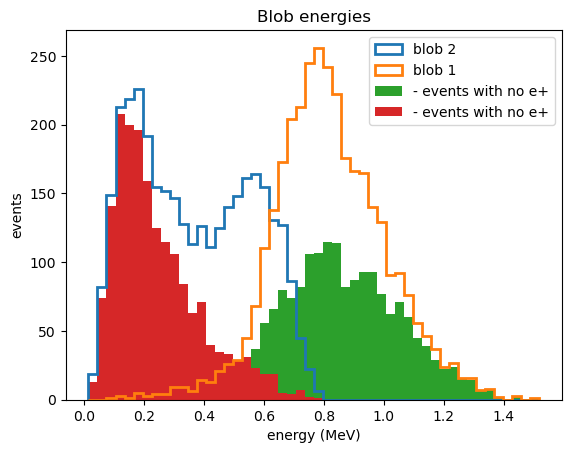

In [51]:
# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()


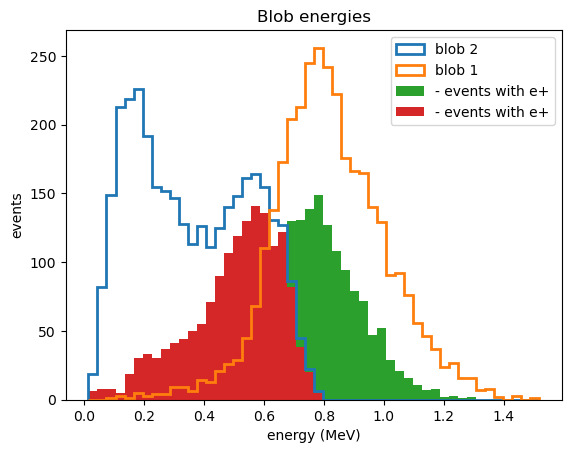

In [52]:
# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_positron_df, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_positron_df, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()


Trying this now with the energy only

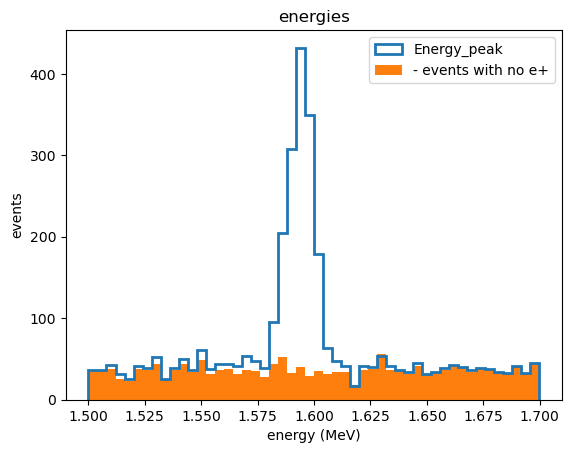

In [53]:
plot_hist(ecut_rel, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = 'Energy_peak', x_label = 'energy (MeV)')
plot_hist(ecut_no_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)')

plt.legend()
plt.show()

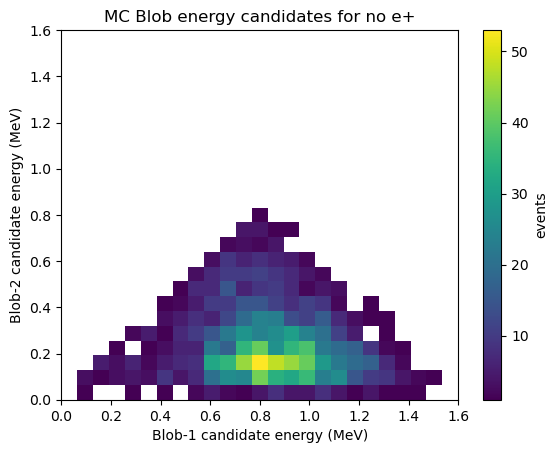

In [54]:
# plot the 2d histogram of blob energies for no positron data
# blob 2dhist
plt.hist2d(ecut_no_positron_df['eblob1'], ecut_no_positron_df['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates for no e+")
plt.show()

#### Apply the fitting to our energy cuts



In [69]:
# lets try this ourselves

def bck_func(x, nb, tau):
    '''
    Function describing the background, an exponential with scaling from Nb and tau
    '''

    return nb*np.exp(-x/tau)

def skewnorm_func(x, a, mu, sigma):
    return skewnorm.pdf(x, a, loc = mu, scale = sigma)

def error_func(x, mu, sigma):
    pas = (x - mu)/(np.sqrt(2)*sigma)
    return special.erfc(pas)


def sig_func(x, ns, a, mu, sigma, C1, C2):
    
    return ns * (skewnorm_func(x, a, mu, sigma) + C1*error_func(x, mu, sigma) + C2)

def sig_bck_func(x, ns, a, mu, sigma, C1, C2, nb, tau):

    return bck_func(x, nb, tau) + sig_func(x, ns, a, mu, sigma, C1, C2)


## attempting without C2 (its a sucky parameter and I hate it)
def sig_func1(x, ns, a, mu, sigma, C1):
    
    return ns * (skewnorm_func(x, a, mu, sigma) + C1*error_func(x, mu, sigma))

def sig_bck_func1(x, ns, a, mu, sigma, C1, nb, tau):

    return bck_func(x, nb, tau) + sig_func1(x, ns, a, mu, sigma, C1)

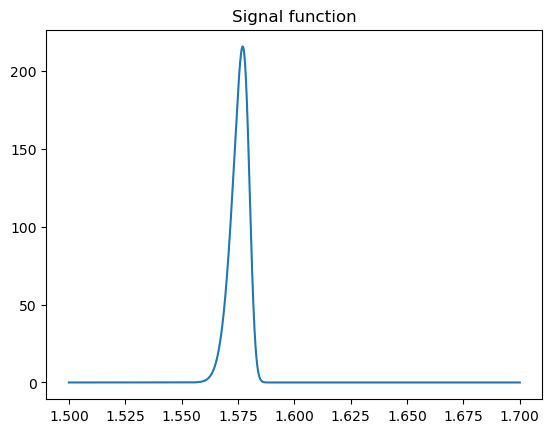

[300, 300]


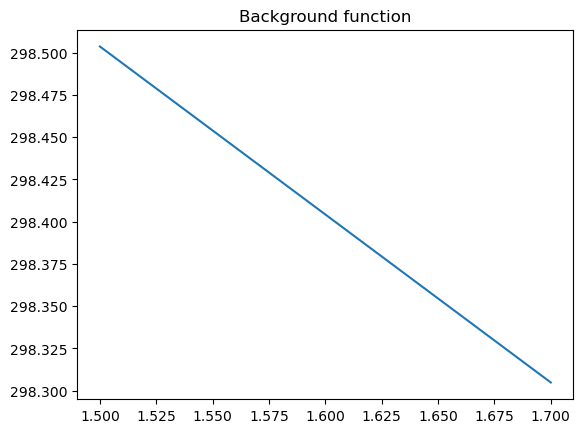

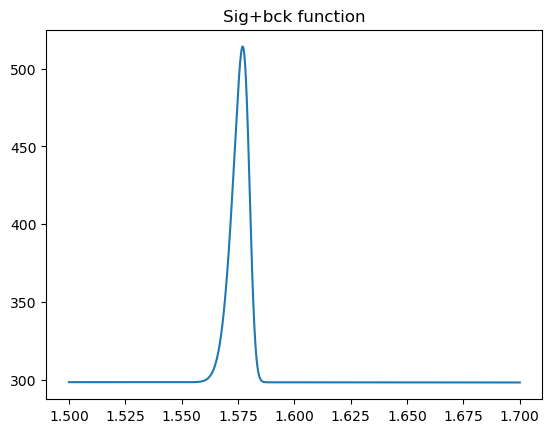

In [56]:
# plot both signal and background functions at specific parameters, for sanity
big_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2', 'nb', 'tau']
p123 = ([2, -2.8, 1.58, 0.006, 0.0003, 0.0001, 300, 300])

x = np.linspace(1.5,1.7, 10000)
y_sig = sig_func(x, *p123[:-2])
plt.title("Signal function")
plt.plot(x,y_sig)
plt.show()
print(p123[-2:])

y_bck = bck_func(x, *p123[-2:])
plt.title("Background function")
plt.plot(x,y_bck)
plt.show()

y_sig_bck = sig_bck_func(x, *p123)
plt.title("Sig+bck function")
plt.plot(x,y_sig_bck)
plt.show()


In [57]:
# create gaussian initially for testing purposes
def gauss(x, a, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)

    return a*np.exp(-numer/denom)




In [58]:
# and a print function
def print_parameters(popt,pcov,labels):
    '''
    Prints fitting parameters

    :param popt:        Fit parameters
    :param pcov:        Fit covariances
    :param labels:      Labels of parameters
    '''
    print('===============================')
    print("        Fitting output      ")
    print('===============================')
    for i in range(len(popt)):
        print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors
    print('===============================')
    return 0


# plot parameters for fit, similar to plot_hist
def plot_fit(function, x, popt, popt_label, output = False, colour = 'red', x_counts = 100000, lgnd = 'Fit'):
    '''
    plots a fit based on individual points and a function
    plots across a more continuous space, to reduce weird artifacting for low X numbers
    '''

    # take much more continuous x axis
    x_min = np.min(x)
    x_max = np.max(x)

    x_plot = np.linspace(x_min, x_max, num = x_counts, endpoint = True)

    y = function(x_plot, *popt)
    plt.plot(x_plot, y, label = lgnd, color = colour)
    for i in range(len(popt)):

        plt.text(1.5, 500 - 25*i, str(popt_label[i]) + ": " + str(round(popt[i], 5)))

    if (output == True):
        plt.show()
    else:
        return


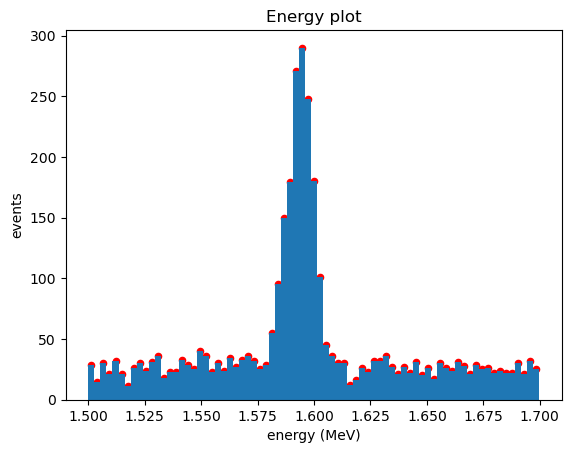

In [59]:
# try fitting gaussian
evalues = ecut_rel['energy'].to_numpy()

e_low = np.min(evalues) 
e_high = np.max(evalues)

# collect heights from histogram of energy
hist, edges, patches = plot_hist(ecut_rel, binning = 75, output = False, data = True)
# convert edges to centres
centres = shift_to_bin_centers(edges)

plt.scatter(centres, hist, color='red', s = 20)
plt.show()

In [60]:
# fit gaussian to this

# p0 is the initial guesses
p0 = ([800, 1.58, 0.04])
gauss_labels = ['a', 'mu','sigma']

popt, pcov = curve_fit(gauss, centres, hist, p0, maxfev = 500000)


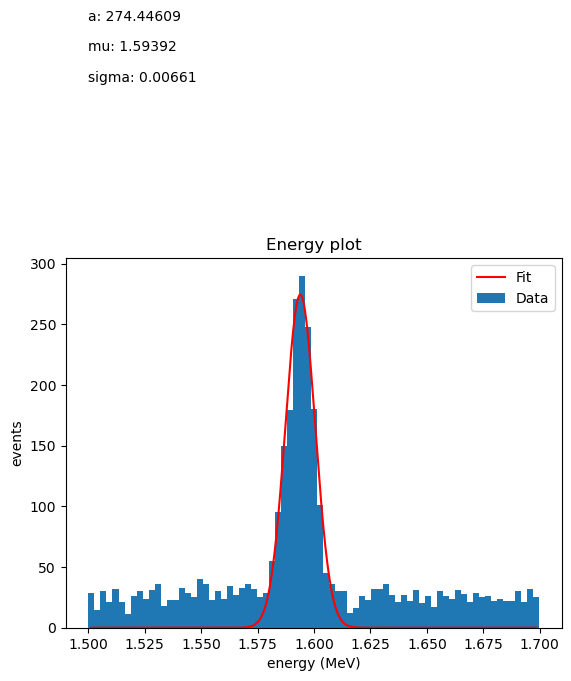

        Fitting output      
a: 274.4461 ± 14.9813
mu: 1.5939 ± 0.0004
sigma: 0.0066 ± 0.0004


0

In [61]:
plot_fit(gauss, centres, popt, gauss_labels)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()
print_parameters(popt, pcov, gauss_labels)

#### Fit with the full fat thing now

In [62]:
# fit full thing to this

# ns -> take as fraction of peak. Example: peak at 1000 events, ns at 1000*8

# p0 is the initial guesses
p1 = ([6400, -2.8, 1.58, 0.006, 0.0003, 0.0001, 3500, 300])
big_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2', 'nb', 'tau']

popt, pcov = curve_fit(sig_bck_func, centres, hist, p1, maxfev = 500000)

In [63]:
print(big_labels[:-2])

['ns', 'a', 'mu', 'sigma', 'C1', 'C2']


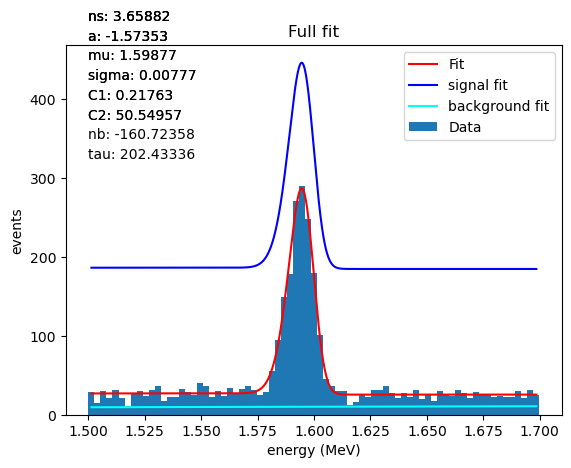

        Fitting output      
ns: 3.6588 ± 0.0887
a: -1.5735 ± 0.2598
mu: 1.5988 ± 0.0004
sigma: 0.0078 ± 0.0004
C1: 0.2176 ± 0.6613
C2: 50.5496 ± 8463403.7160
nb: -160.7236 ± 30965058.2512
tau: 202.4334 ± 39314069.2802


0

In [64]:
plot_fit(sig_bck_func, centres, popt, big_labels)
plot_fit(sig_func, centres, popt[:-2], big_labels[:-2], lgnd='signal fit', colour = 'blue')
plot_fit(bck_func, centres, popt[:2], big_labels[:2], lgnd='background fit', colour = 'cyan')
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data', title='Full fit')
plt.legend()
plt.show()
print_parameters(popt, pcov, big_labels)

### It looks awful, lets try without C2 (it sucks)

In [70]:
# p0 is the initial guesses
p1 = ([6400, -2.8, 1.58, 0.006, 0.0003, 3500, 300])
big_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'nb', 'tau']

popt, pcov = curve_fit(sig_bck_func1, centres, hist, p1, maxfev = 500000)

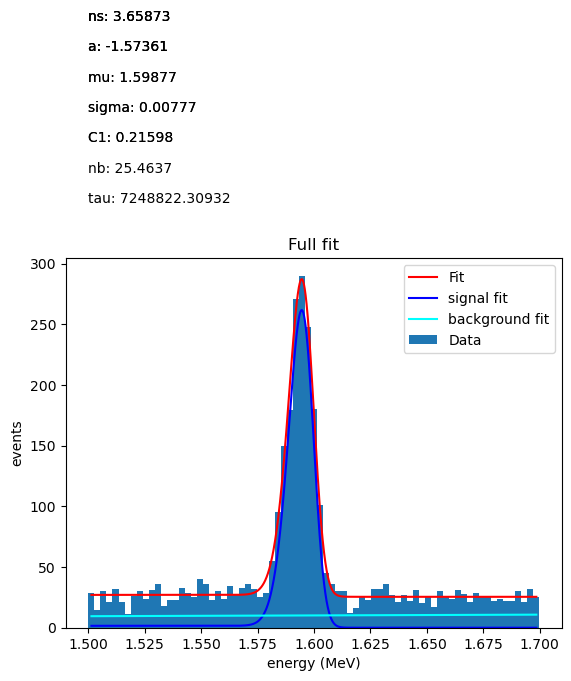

        Fitting output      
ns: 3.6587 ± 0.0699
a: -1.5736 ± 0.2367
mu: 1.5988 ± 0.0004
sigma: 0.0078 ± 0.0004
C1: 0.2160 ± 0.3850
nb: 25.4637 ± 31.5328
tau: 7248822.3093 ± 18828121236596.1836


0

In [72]:
plot_fit(sig_bck_func1, centres, popt, big_labels)
plot_fit(sig_func1, centres, popt[:-2], big_labels[:-2], lgnd='signal fit', colour = 'blue')
plot_fit(bck_func, centres, popt[:2], big_labels[:2], lgnd='background fit', colour = 'cyan')
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data', title='Full fit')
plt.legend()
plt.show()
print_parameters(popt, pcov, big_labels)

### Try here with flat background

#### Create fom for blob 2 cuts

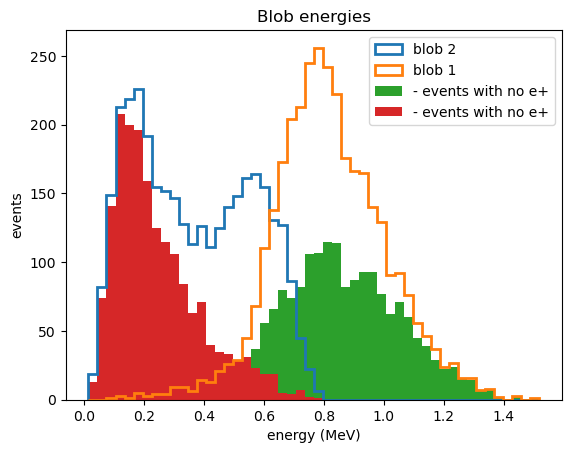

In [73]:
def blob_positron_plot(ecut_rel, ecut_no_positron_df, save = False, save_title = 'plot.png'):
    '''
    Plots the blob energies with and without positrons.
    '''

    # the original way
    plot_hist(ecut_rel, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_rel, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    #plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
    #plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

    plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    plt.legend()

    if (save == True):
        plt.savefig(save_title)
    plt.show()

blob_positron_plot(ecut_rel, ecut_no_positron_df)

In [78]:
def default_fit(data, bins = 75, verbose = False):
    '''
    Apply the expected fit to the data here,
    '''

    # find minima and maxima
    evalues = data['energy'].to_numpy()
    e_low = np.min(evalues) 
    e_high = np.max(evalues)

    # collect heights from histogram of energy
    hist, edges, patches = plot_hist(data, binning = bins, output = False, data = True)
    # convert edges to centres
    centres = shift_to_bin_centers(edges)


    # collect assumptions
    p1 = ([6400, -2.8, 1.58, 0.006, 0.0003, 3500, 300])
    big_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'nb', 'tau']

    # fit function
    popt, pcov = curve_fit(sig_bck_func1, centres, hist, p1, maxfev = 1000000)

    if (verbose == True):
        plot_fit(sig_bck_func1, centres, popt, big_labels)
        plot_fit(sig_func1, centres, popt[:-2], big_labels[:-2], lgnd='signal fit', colour = 'blue')
        plot_fit(bck_func, centres, popt[:2], big_labels[:2], lgnd='background fit', colour = 'cyan')
        plot_hist(data, binning = bins, output = False, data = True, label='Data', title='Full fit')
        plt.legend()
        plt.show()
        print_parameters(popt, pcov, big_labels)
    
    # return ns and nb calculations
    ns = popt[0]
    nb = popt[-2]

    return (ns, nb)
        



def fom_calc(data, no_pos_data, cut_list, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    '''

    if (verbose == True):
        blob_positron_plot(data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    output = default_fit(data, verbose = True)
    ns0 = output[0]
    nb0 = output[1]
    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        
        # remove blob 2 values below value on cut_list
        data = data[(data['eblob2'] > cut_list[i])]
        no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]
        # apply fit to the new data 
        if (verbose == True):
            output = default_fit(data, verbose = True)
        else:
            output = default_fit(data, verbose = False)
        ns = output[0]
        nb = output[1]

        # produce fom value
        e.append(ns/ns0)
        b.append(nb/nb0)
        fom.append(e[i]/np.sqrt(b[i]))

        if (verbose == True):
            blob_positron_plot(data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom






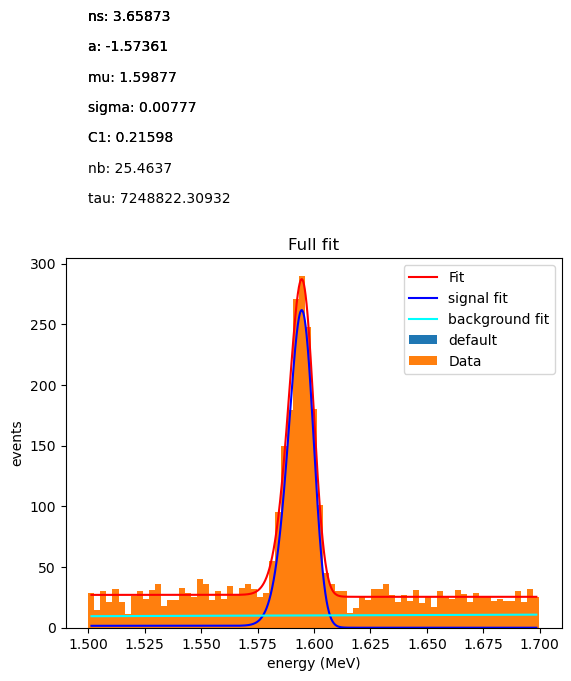

        Fitting output      
ns: 3.6587 ± 0.0699
a: -1.5736 ± 0.2367
mu: 1.5988 ± 0.0004
sigma: 0.0078 ± 0.0004
C1: 0.2160 ± 0.3850
nb: 25.4637 ± 31.5328
tau: 7248822.3093 ± 18828121236596.1836


(3.6587345899050323, 25.463704809237)

In [79]:
# testing that it works as intended
default_fit(ecut_rel, verbose = True)

In [80]:
# create deep copies of ecut_rel here for testing/safety
fitting_data = ecut_rel.copy(deep = True)
fitting_data_nopos = ecut_no_positron_df.copy(deep = True)

Cut list: [0.         0.02083333 0.04166667 0.0625     0.08333333 0.10416667
 0.125      0.14583333 0.16666667 0.1875     0.20833333 0.22916667
 0.25       0.27083333 0.29166667 0.3125     0.33333333 0.35416667
 0.375      0.39583333 0.41666667 0.4375     0.45833333 0.47916667
 0.5       ]


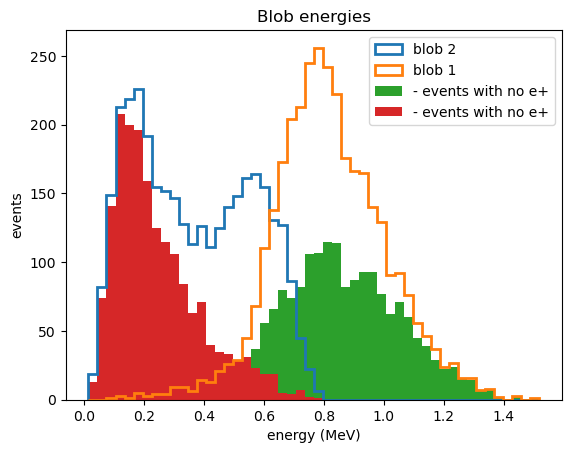

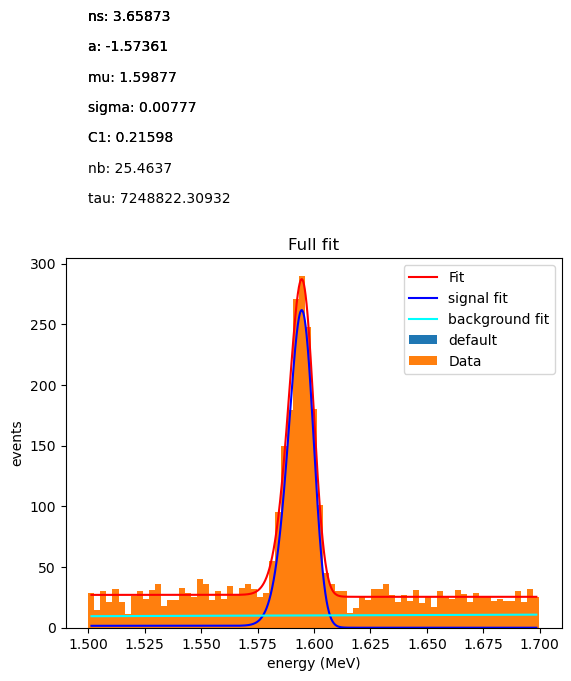

        Fitting output      
ns: 3.6587 ± 0.0699
a: -1.5736 ± 0.2367
mu: 1.5988 ± 0.0004
sigma: 0.0078 ± 0.0004
C1: 0.2160 ± 0.3850
nb: 25.4637 ± 31.5328
tau: 7248822.3093 ± 18828121236596.1836


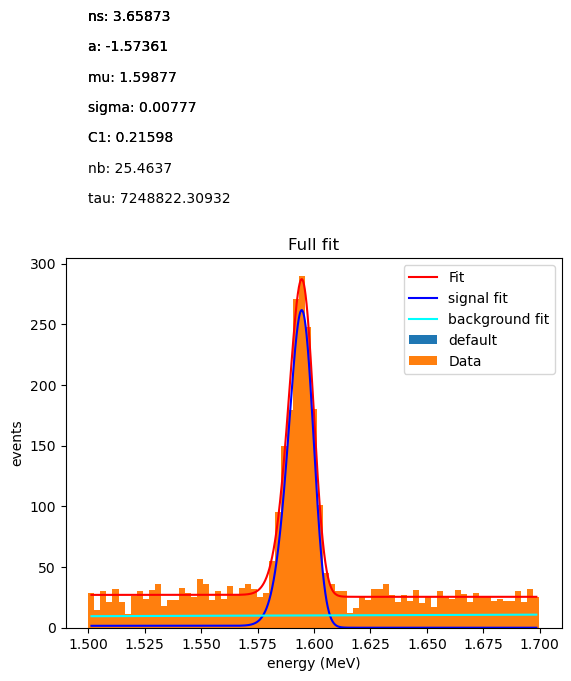

        Fitting output      
ns: 3.6587 ± 0.0699
a: -1.5736 ± 0.2367
mu: 1.5988 ± 0.0004
sigma: 0.0078 ± 0.0004
C1: 0.2160 ± 0.3850
nb: 25.4637 ± 31.5328
tau: 7248822.3093 ± 18828121236596.1836


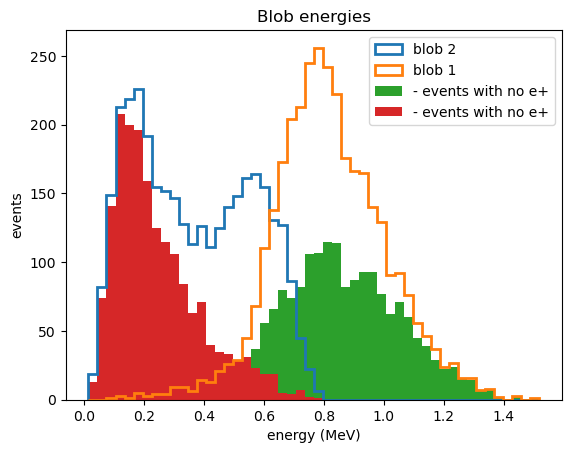

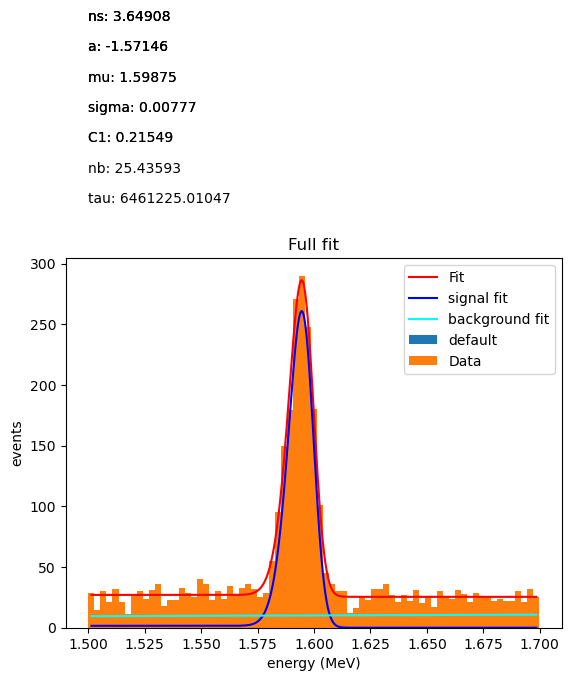

        Fitting output      
ns: 3.6491 ± 0.0827
a: -1.5715 ± 0.2596
mu: 1.5988 ± 0.0004
sigma: 0.0078 ± 0.0004
C1: 0.2155 ± 0.2973
nb: 25.4359 ± 19.7882
tau: 6461225.0105 ± 19624998382374.2773


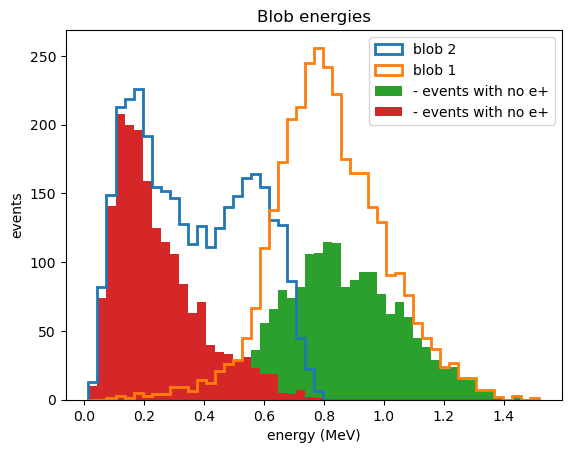

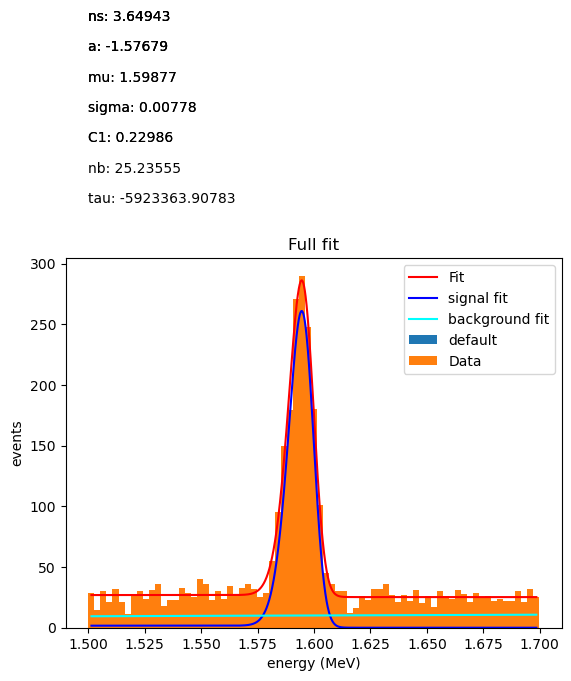

        Fitting output      
ns: 3.6494 ± 0.0698
a: -1.5768 ± 0.2431
mu: 1.5988 ± 0.0004
sigma: 0.0078 ± 0.0004
C1: 0.2299 ± 0.2921
nb: 25.2355 ± 17.9530
tau: -5923363.9078 ± 15063599058392.5684


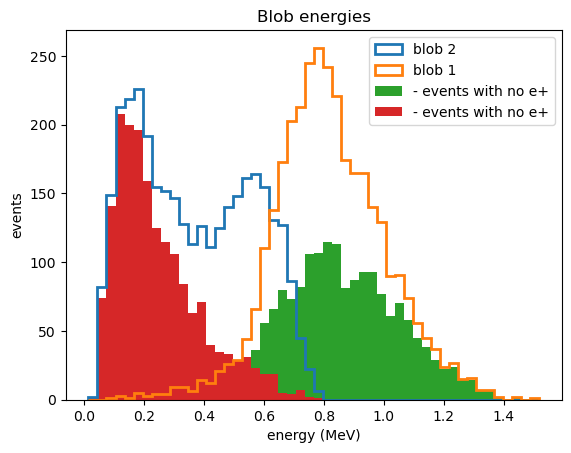

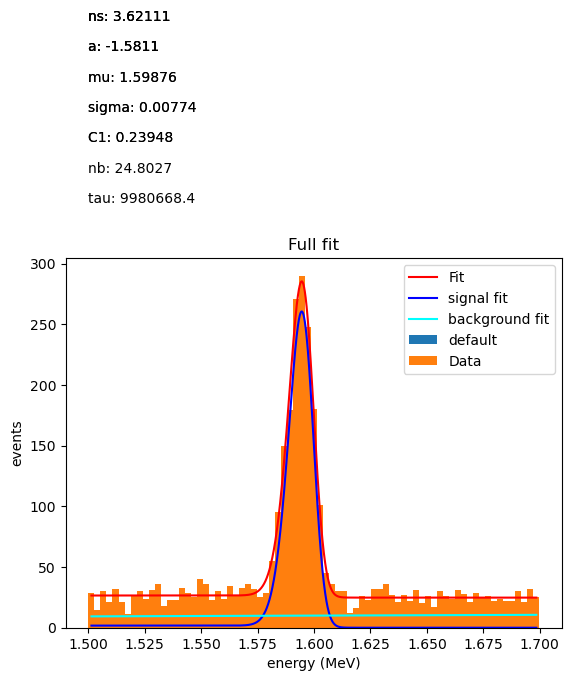

        Fitting output      
ns: 3.6211 ± 0.0680
a: -1.5811 ± 0.2580
mu: 1.5988 ± 0.0004
sigma: 0.0077 ± 0.0004
C1: 0.2395 ± 0.3277
nb: 24.8027 ± 23.9901
tau: 9980668.4000 ± 8789281877261.1074


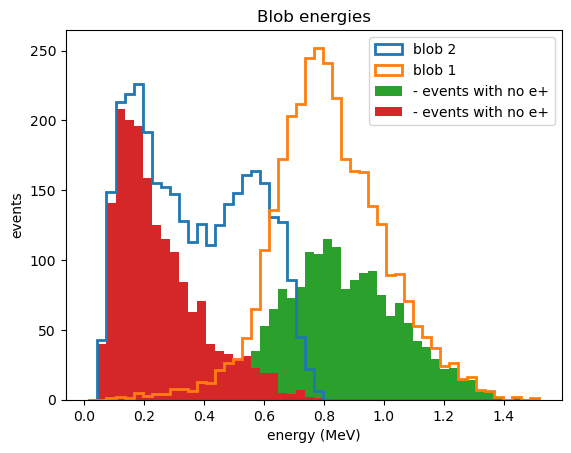

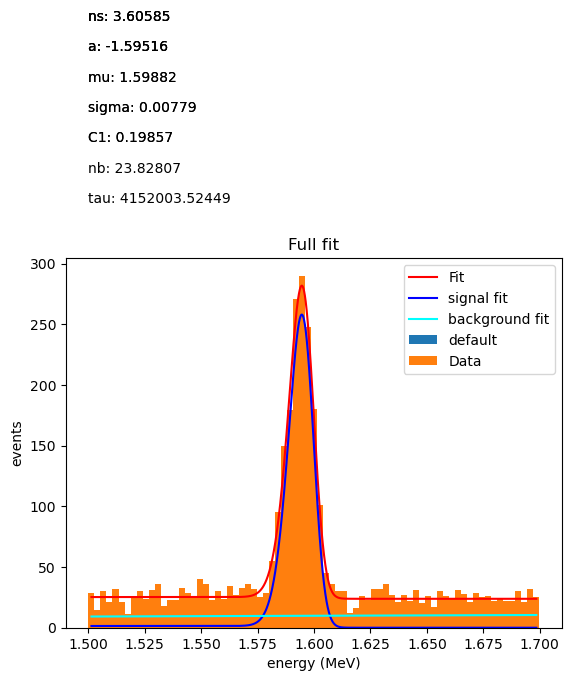

        Fitting output      
ns: 3.6059 ± 0.0679
a: -1.5952 ± 0.2430
mu: 1.5988 ± 0.0004
sigma: 0.0078 ± 0.0004
C1: 0.1986 ± 0.4200
nb: 23.8281 ± 35.9752
tau: 4152003.5245 ± 2730315705435.4575


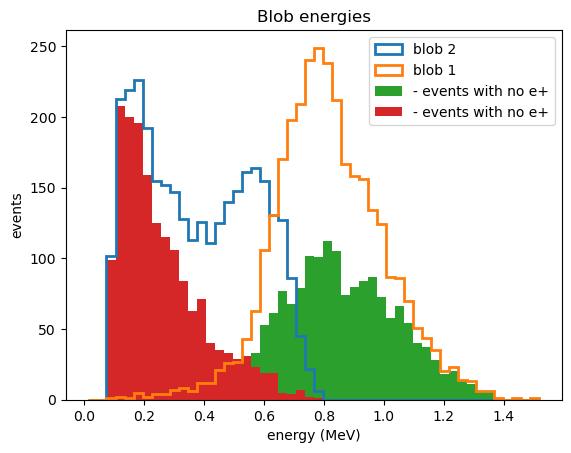

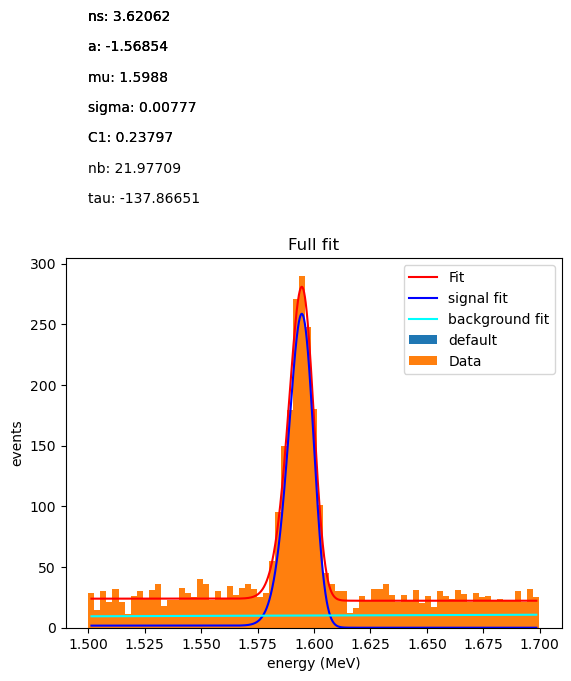

        Fitting output      
ns: 3.6206 ± 0.0693
a: -1.5685 ± 0.2415
mu: 1.5988 ± 0.0004
sigma: 0.0078 ± 0.0004
C1: 0.2380 ± 0.6099
nb: 21.9771 ± 56.8633
tau: -137.8665 ± 29713.3725


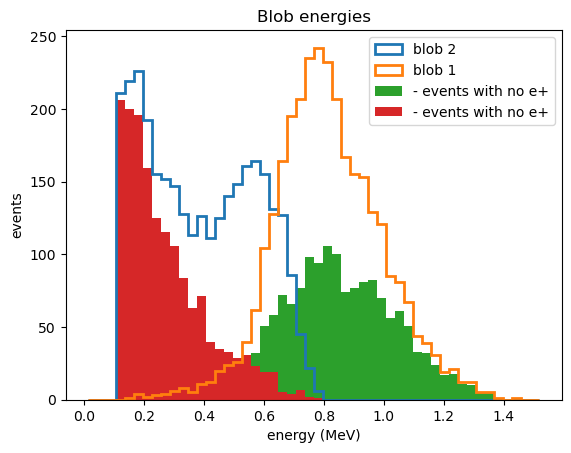

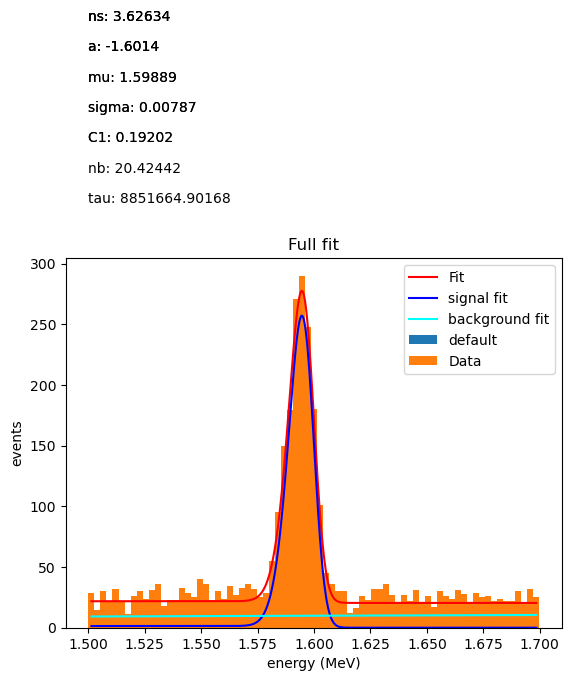

        Fitting output      
ns: 3.6263 ± 0.0612
a: -1.6014 ± 0.2109
mu: 1.5989 ± 0.0003
sigma: 0.0079 ± 0.0004
C1: 0.1920 ± 0.2734
nb: 20.4244 ± 17.4309
tau: 8851664.9017 ± 15067481796996.5820


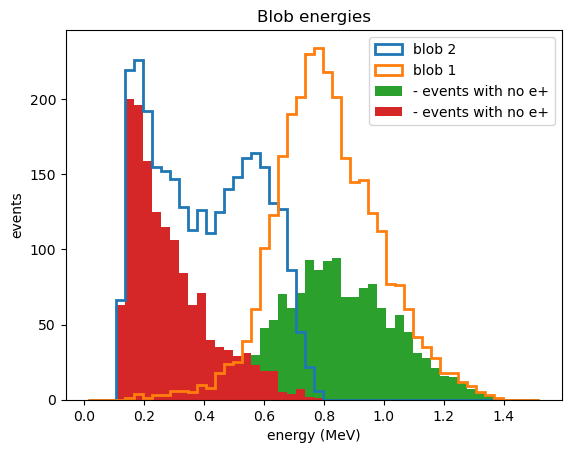

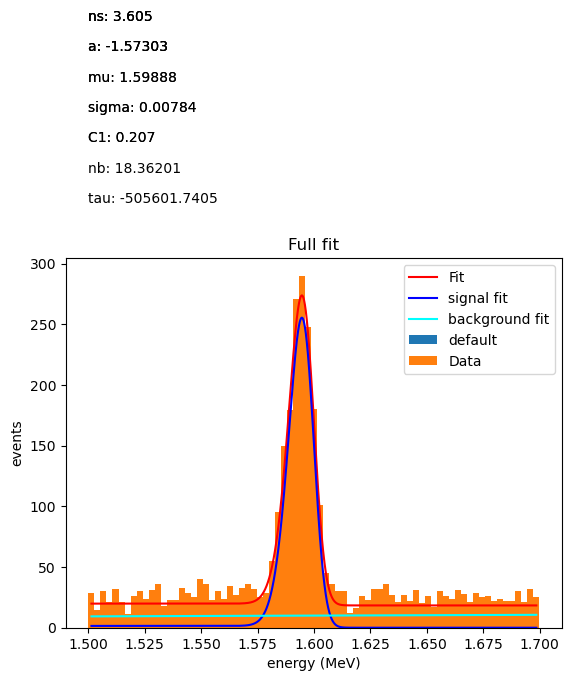

        Fitting output      
ns: 3.6050 ± 0.0688
a: -1.5730 ± 0.2263
mu: 1.5989 ± 0.0003
sigma: 0.0078 ± 0.0004
C1: 0.2070 ± 0.4680
nb: 18.3620 ± 41.6773
tau: -505601.7405 ± 1886583405111.6938


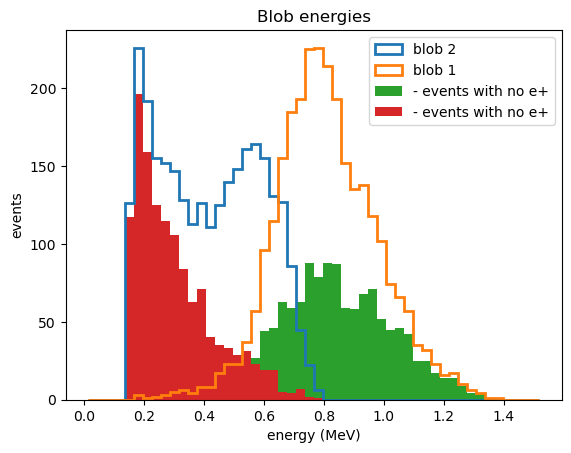

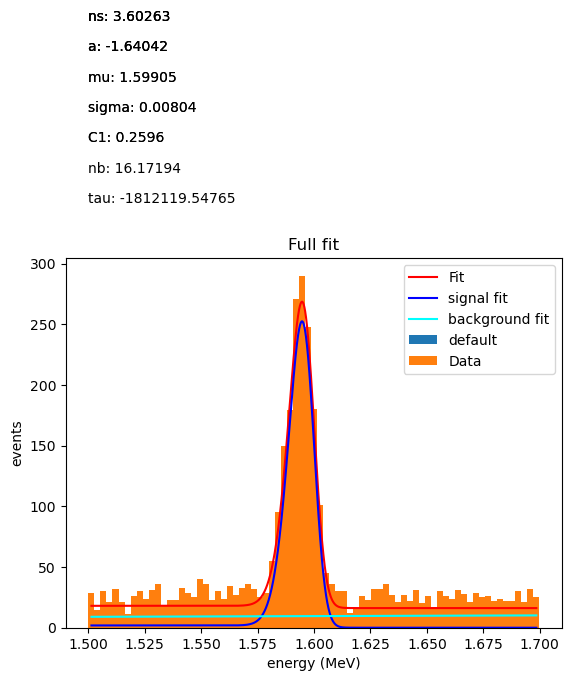

        Fitting output      
ns: 3.6026 ± 0.0566
a: -1.6404 ± 0.1962
mu: 1.5990 ± 0.0003
sigma: 0.0080 ± 0.0003
C1: 0.2596 ± 0.2342
nb: 16.1719 ± 14.0595
tau: -1812119.5476 ± 14263356829378.8633


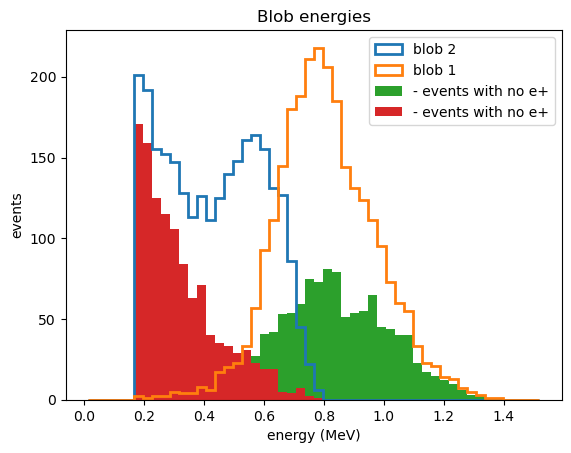

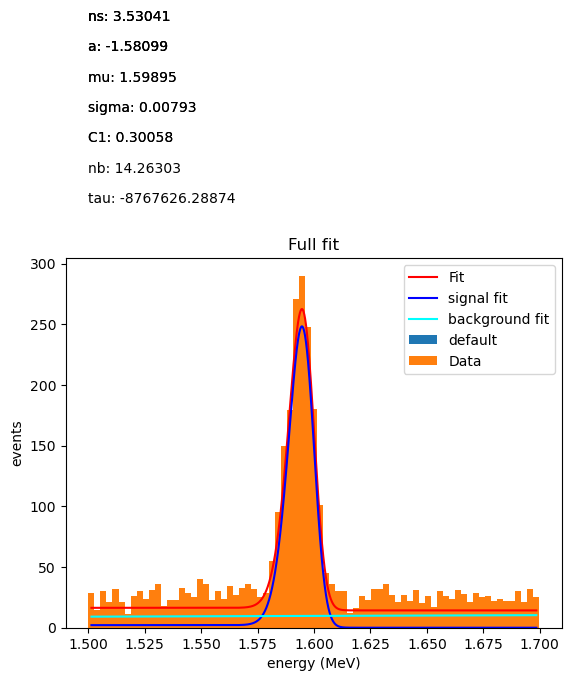

        Fitting output      
ns: 3.5304 ± 0.0533
a: -1.5810 ± 0.1889
mu: 1.5990 ± 0.0003
sigma: 0.0079 ± 0.0003
C1: 0.3006 ± 0.2193
nb: 14.2630 ± 10.6393
tau: -8767626.2887 ± 20051953498010.2070


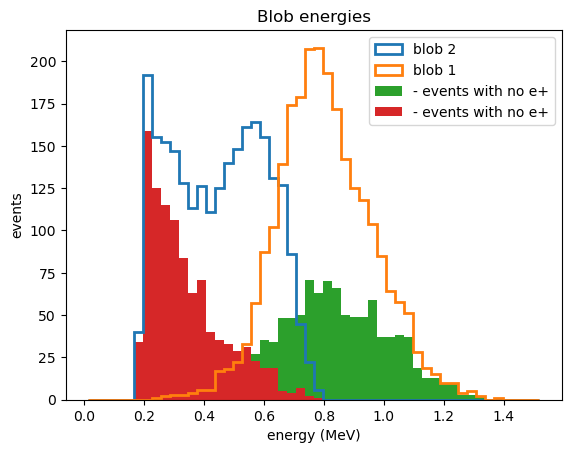

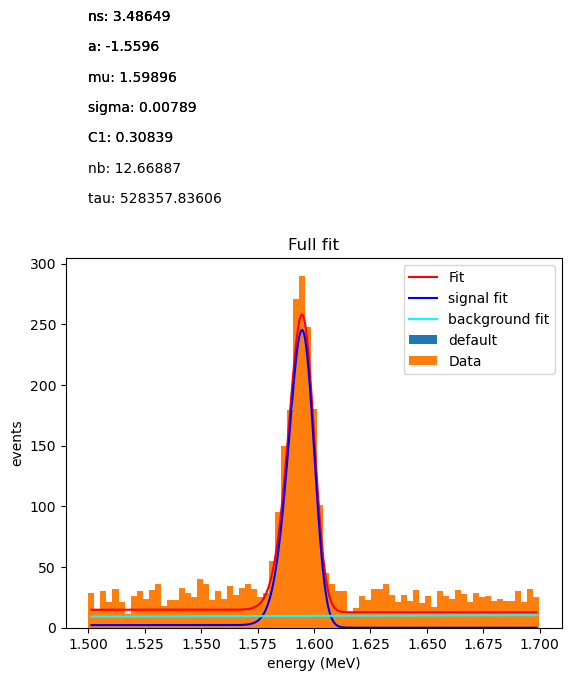

        Fitting output      
ns: 3.4865 ± 0.0544
a: -1.5596 ± 0.1913
mu: 1.5990 ± 0.0003
sigma: 0.0079 ± 0.0003
C1: 0.3084 ± 0.4708
nb: 12.6689 ± 42.7769
tau: 528357.8361 ± 569849917347.4143


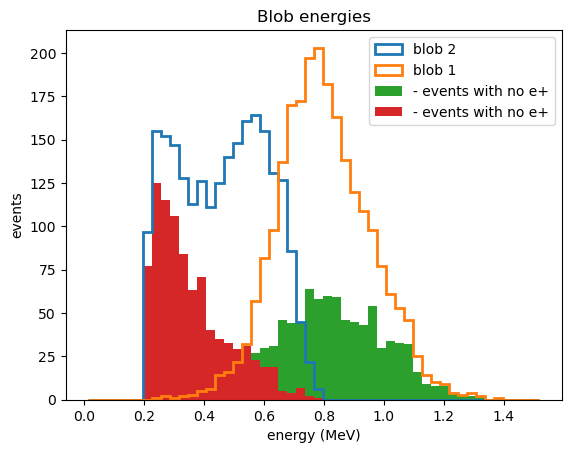

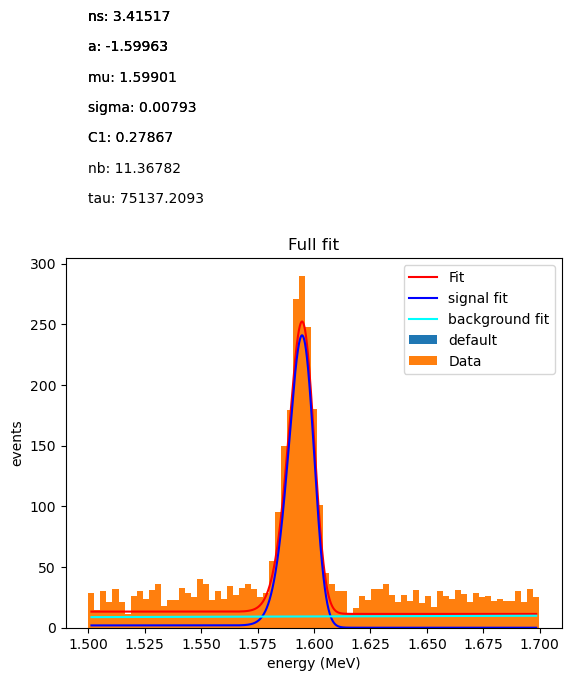

        Fitting output      
ns: 3.4152 ± 0.0531
a: -1.5996 ± 0.1919
mu: 1.5990 ± 0.0003
sigma: 0.0079 ± 0.0003
C1: 0.2787 ± 0.4863
nb: 11.3678 ± 43.1659
tau: 75137.2093 ± 12952379902.5925


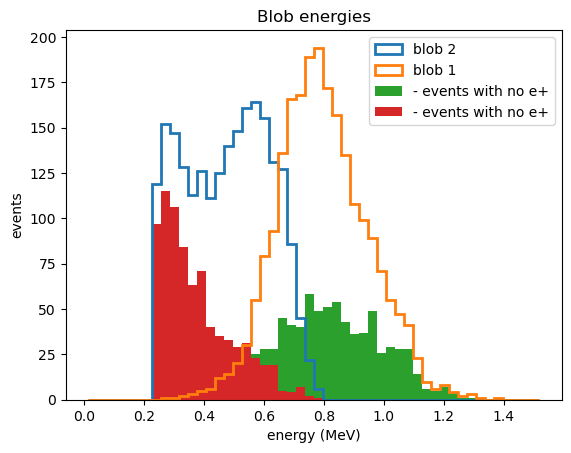

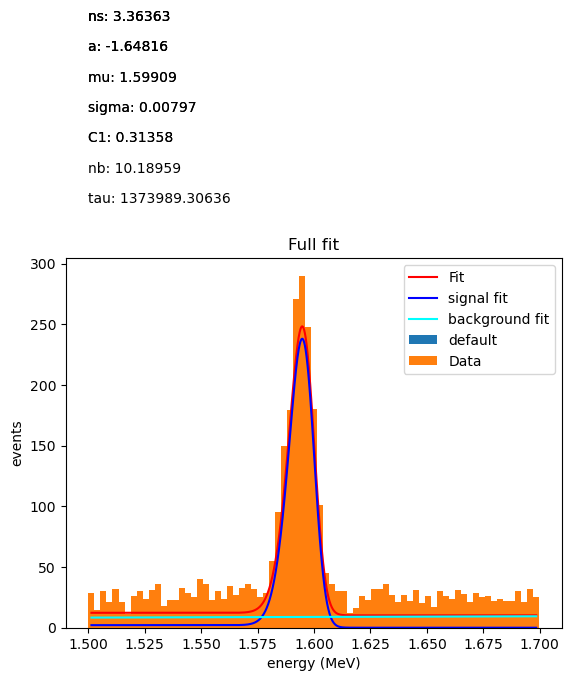

        Fitting output      
ns: 3.3636 ± 0.0512
a: -1.6482 ± 0.2375
mu: 1.5991 ± 0.0004
sigma: 0.0080 ± 0.0004
C1: 0.3136 ± 0.3447
nb: 10.1896 ± 25.7263
tau: 1373989.3064 ± 7979534926779.1270


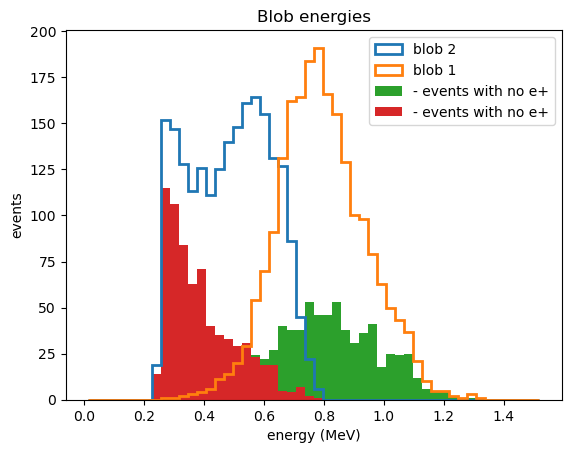

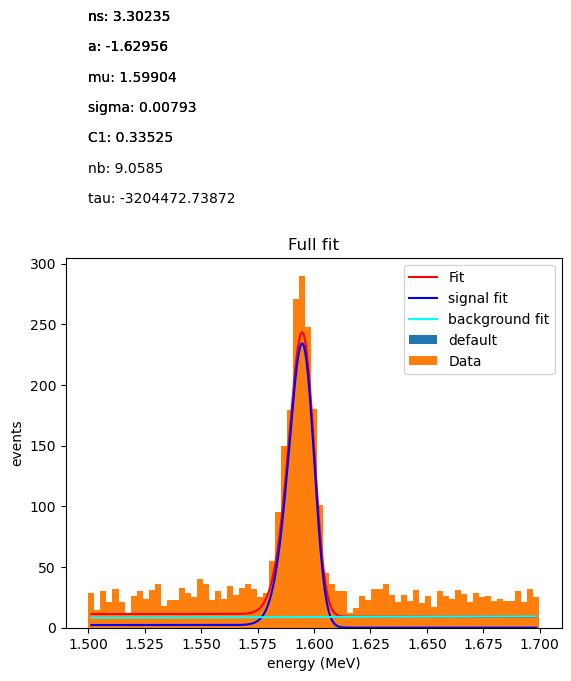

        Fitting output      
ns: 3.3023 ± 0.0493
a: -1.6296 ± 0.1902
mu: 1.5990 ± 0.0003
sigma: 0.0079 ± 0.0003
C1: 0.3352 ± 0.2290
nb: 9.0585 ± 11.4804
tau: -3204472.7387 ± 7821148648484.9951


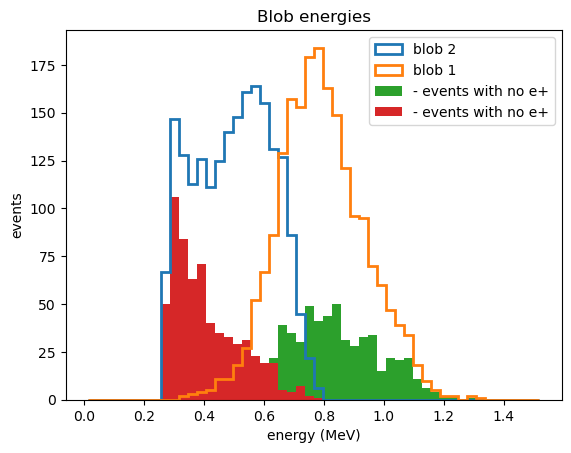

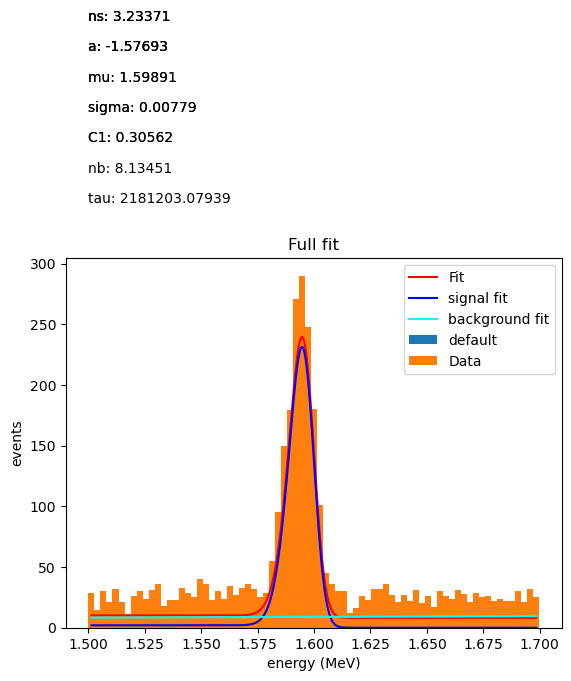

        Fitting output      
ns: 3.2337 ± 0.0535
a: -1.5769 ± 0.2462
mu: 1.5989 ± 0.0004
sigma: 0.0078 ± 0.0004
C1: 0.3056 ± 0.2796
nb: 8.1345 ± 19.0483
tau: 2181203.0794 ± 6726777289849.1572


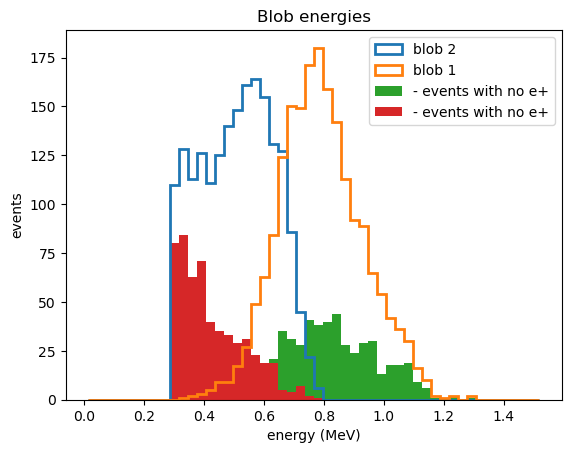

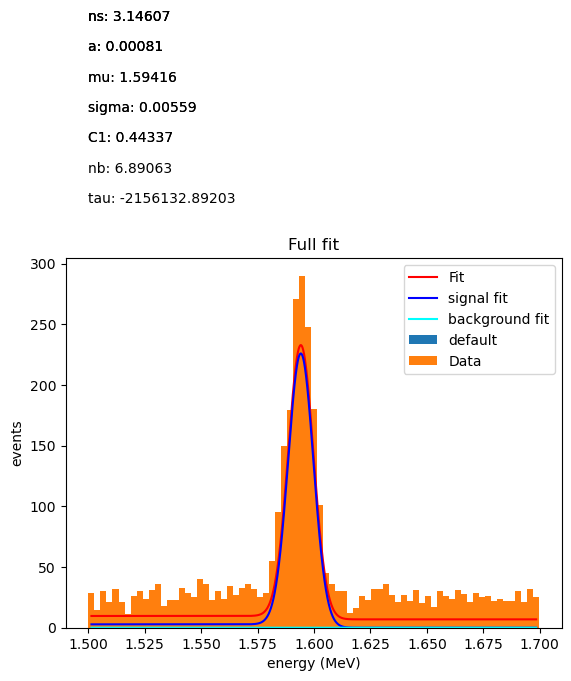

        Fitting output      
ns: 3.1461 ± 41.6336
a: 0.0008 ± 3345.6093
mu: 1.5942 ± 14.9194
sigma: 0.0056 ± 0.0098
C1: 0.4434 ± 5.8123
nb: 6.8906 ± 27.5897
tau: -2156132.8920 ± 11258398715032.9688


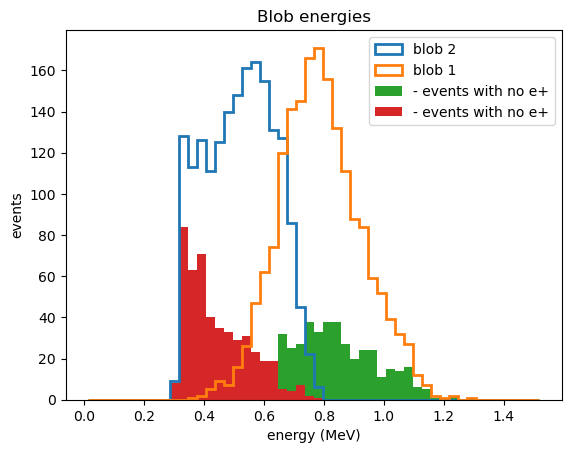

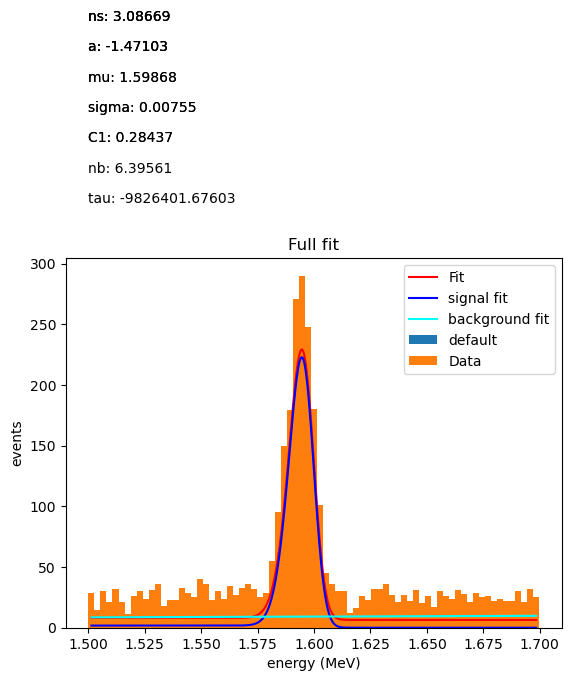

        Fitting output      
ns: 3.0867 ± 0.0413
a: -1.4710 ± 0.1739
mu: 1.5987 ± 0.0003
sigma: 0.0076 ± 0.0003
C1: 0.2844 ± 0.1732
nb: 6.3956 ± 2.2789
tau: -9826401.6760 ± 19495852634131.7539


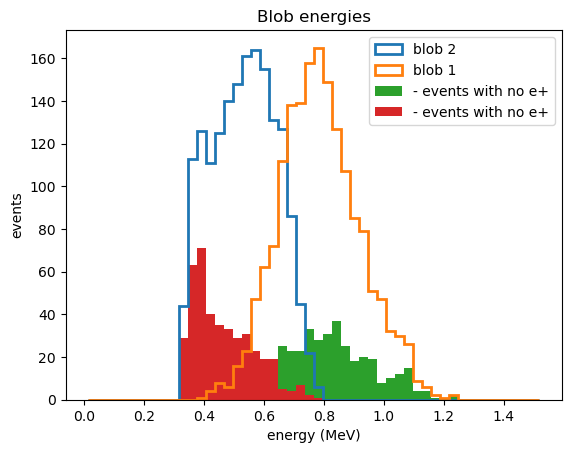

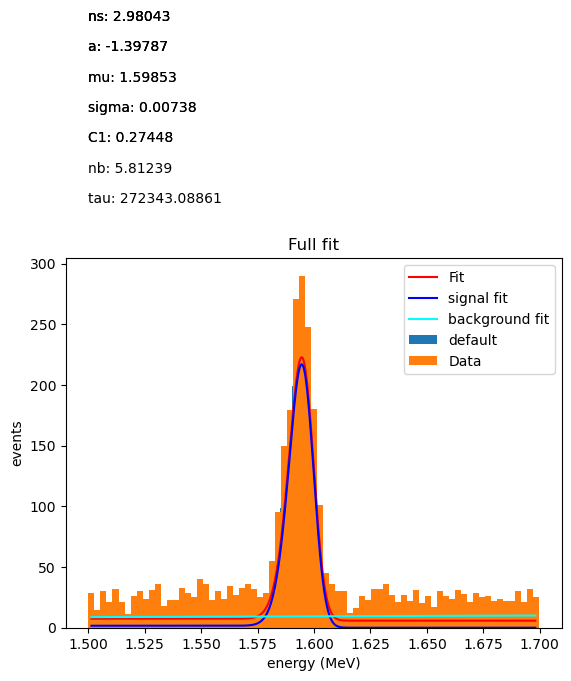

        Fitting output      
ns: 2.9804 ± 0.0377
a: -1.3979 ± 0.1950
mu: 1.5985 ± 0.0003
sigma: 0.0074 ± 0.0003
C1: 0.2745 ± 0.2063
nb: 5.8124 ± 9.8553
tau: 272343.0886 ± 6600300301420.5293


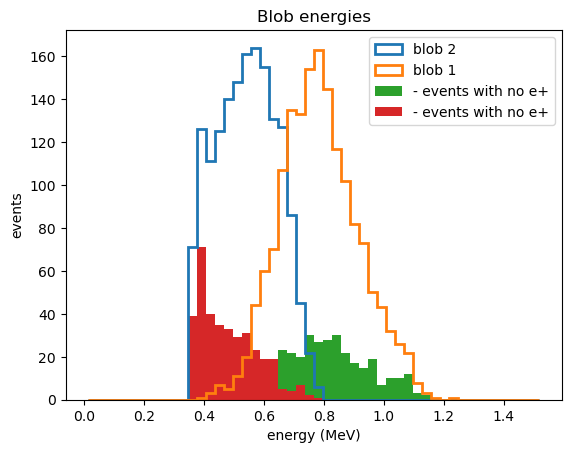

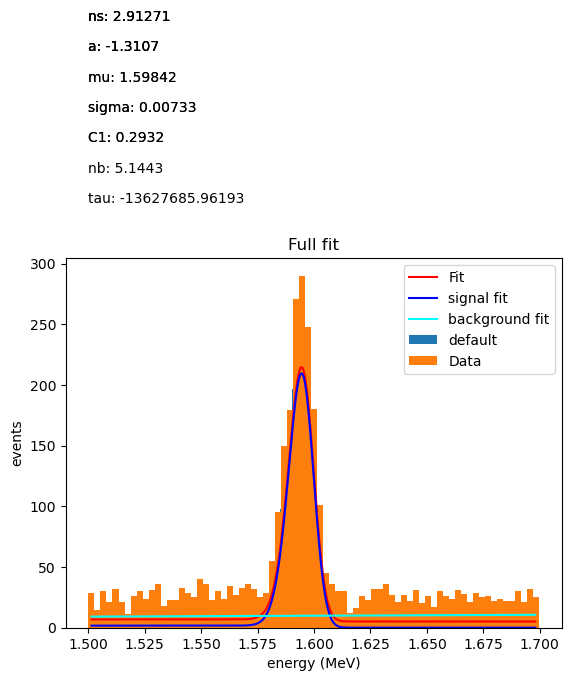

        Fitting output      
ns: 2.9127 ± 0.0423
a: -1.3107 ± 0.1826
mu: 1.5984 ± 0.0004
sigma: 0.0073 ± 0.0003
C1: 0.2932 ± 0.1725
nb: 5.1443 ± 1.5970
tau: -13627685.9619 ± 31665843644227.8398


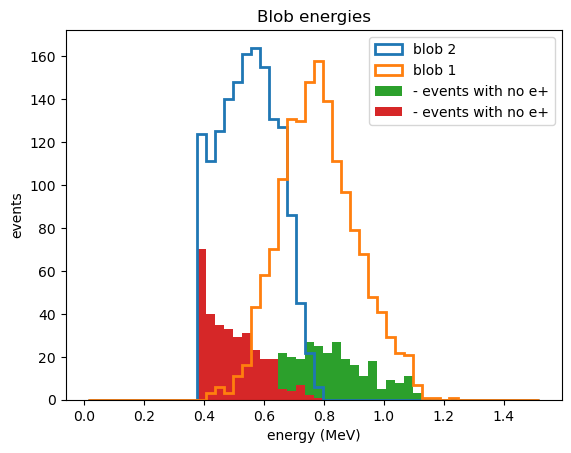

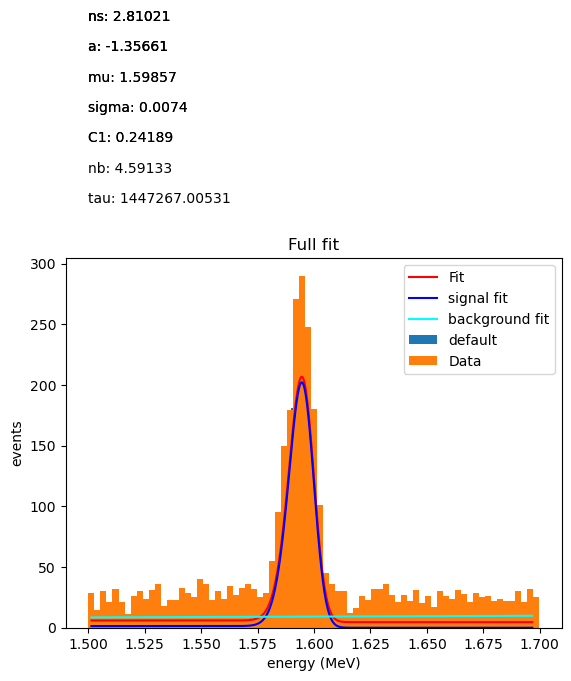

        Fitting output      
ns: 2.8102 ± 0.0441
a: -1.3566 ± 0.2613
mu: 1.5986 ± 0.0005
sigma: 0.0074 ± 0.0004
C1: 0.2419 ± 0.2554
nb: 4.5913 ± 12.0967
tau: 1447267.0053 ± 9688044843391.1074


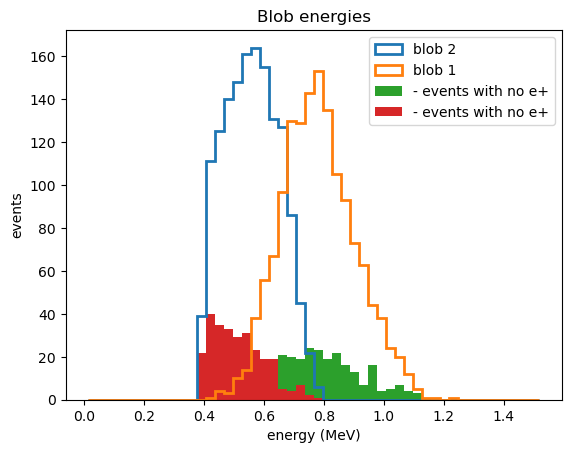

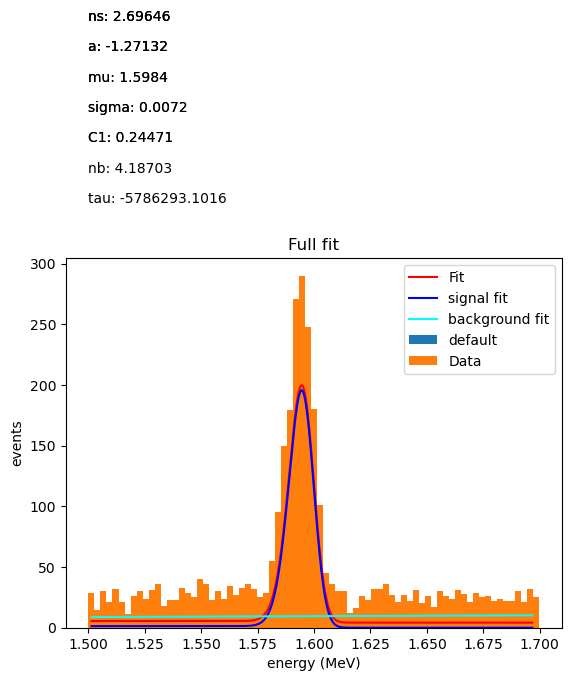

        Fitting output      
ns: 2.6965 ± 0.0746
a: -1.2713 ± 0.2290
mu: 1.5984 ± 0.0004
sigma: 0.0072 ± 0.0004
C1: 0.2447 ± 0.3799
nb: 4.1870 ± 24.5441
tau: -5786293.1016 ± 34136922378754.0156


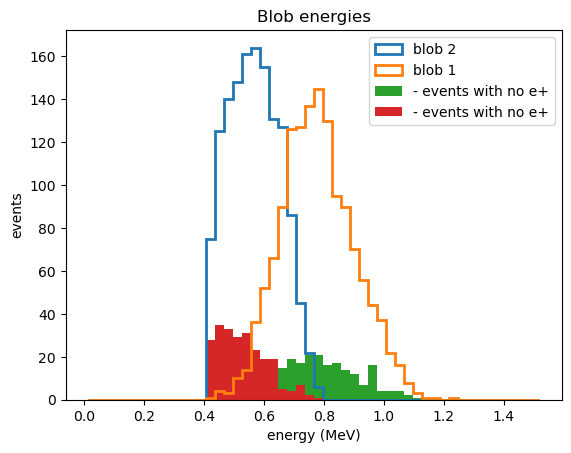

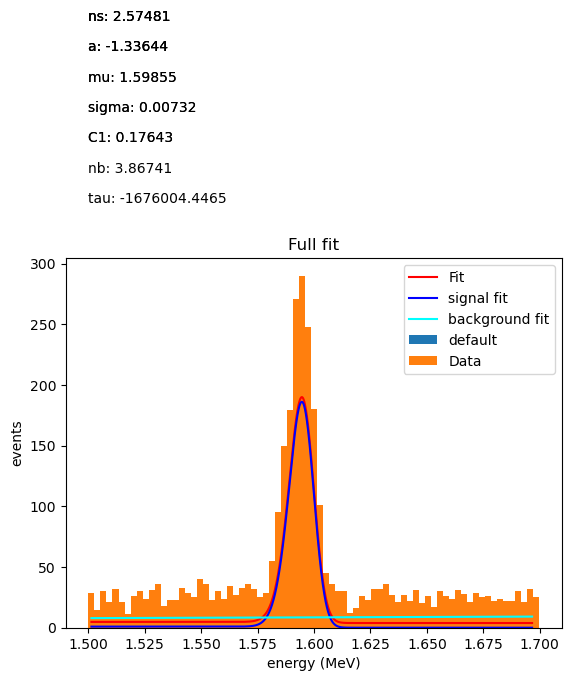

        Fitting output      
ns: 2.5748 ± 0.0459
a: -1.3364 ± 0.2119
mu: 1.5985 ± 0.0004
sigma: 0.0073 ± 0.0004
C1: 0.1764 ± 0.3772
nb: 3.8674 ± 24.1059
tau: -1676004.4465 ± 10590260665730.4238


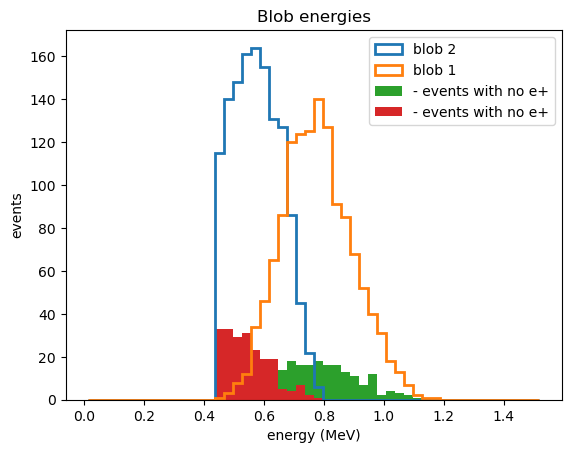

/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


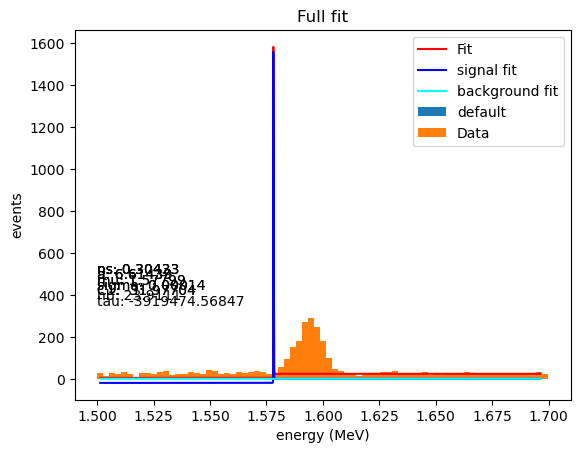

        Fitting output      
ns: 0.3043 ± inf
a: 6.6144 ± inf
mu: 1.5780 ± inf
sigma: 0.0001 ± inf
C1: -31.9770 ± inf
nb: 23.9111 ± inf
tau: -3919474.5685 ± inf


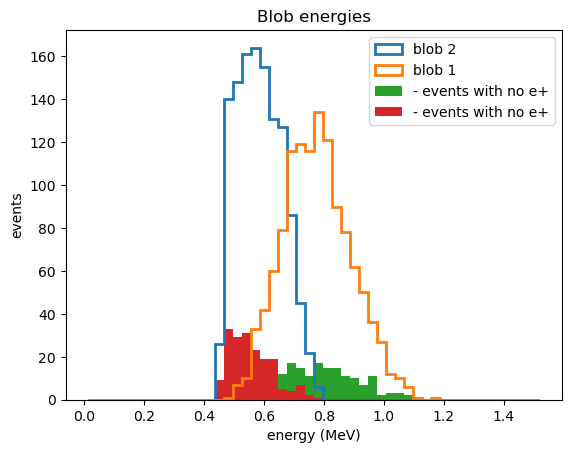

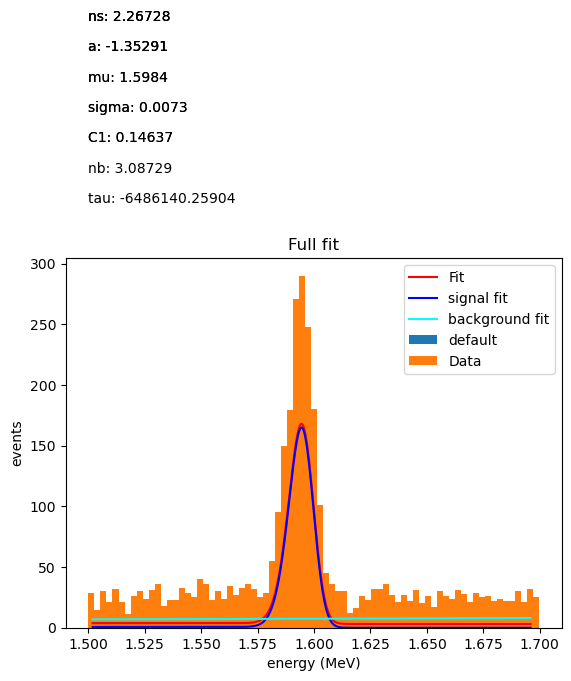

        Fitting output      
ns: 2.2673 ± 0.0385
a: -1.3529 ± 0.2504
mu: 1.5984 ± 0.0005
sigma: 0.0073 ± 0.0004
C1: 0.1464 ± 0.2328
nb: 3.0873 ± 5.3085
tau: -6486140.2590 ± 6968118020105.0703


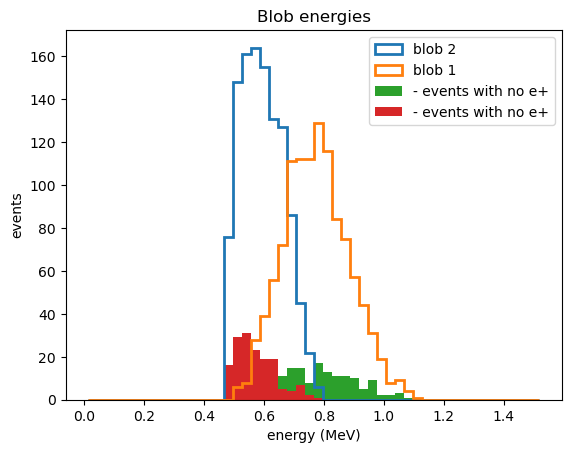

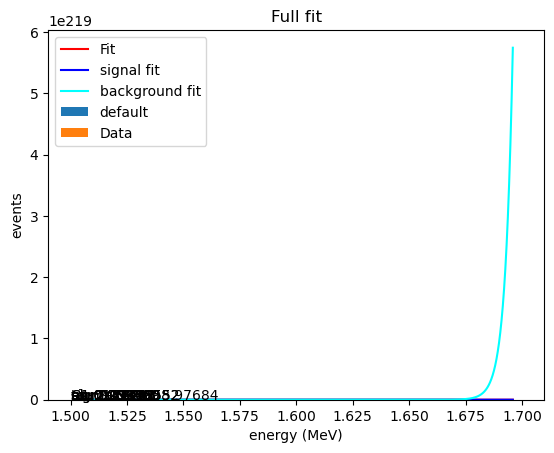

        Fitting output      
ns: 2.0938 ± 20.8545
a: -0.0034 ± 4008.7526
mu: 1.5941 ± 17.6465
sigma: 0.0055 ± 0.0472
C1: 0.2821 ± 2.8080
nb: 2.4446 ± 16.7173
tau: -2095508.9768 ± 18169639501922.2617


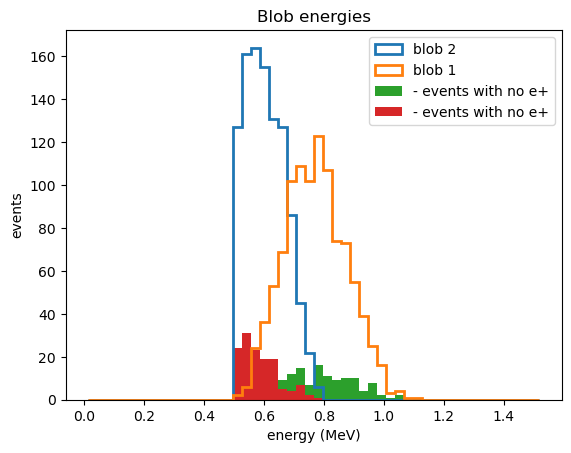

In [81]:
# creating cut list
cut_list = np.linspace(0, 0.5, 25)

# test first
#cut_list = [0.1, 0.2, 0.3, 0.4, 0.5]
print("Cut list: {}".format(cut_list))
fom = fom_calc(fitting_data, fitting_data_nopos, cut_list, verbose=True)

[1.0, 0.9979051635618759, 1.0019557423119174, 1.0028187123504082, 1.0188108114382133, 1.0651919924787006, 1.1066847815887315, 1.1603117775511183, 1.23557482173207, 1.2892861158449718, 1.3509797336637952, 1.3970230090502445, 1.453312796899541, 1.5132990381791127, 1.5637451032520528, 1.6529828535504223, 1.6833817686387484, 1.7050272687169932, 1.7711836986252336, 1.8088356016883875, 1.8174844648163488, 1.8057812236676032, 0.0858356974974852, 1.7796955142067048, 1.846962312929048]
[1.         0.99790516 1.00195574 1.00281871 1.01881081 1.06519199
 1.10668478 1.16031178 1.23557482 1.28928612 1.35097973 1.39702301
 1.4533128  1.51329904 1.5637451  1.65298285 1.68338177 1.70502727
 1.7711837  1.8088356  1.81748446 1.80578122 0.0858357  1.77969551
 1.84696231]
[0.         0.02083333 0.04166667 0.0625     0.08333333 0.10416667
 0.125      0.14583333 0.16666667 0.1875     0.20833333 0.22916667
 0.25       0.27083333 0.29166667 0.3125     0.33333333 0.35416667
 0.375      0.39583333 0.41666667 0.

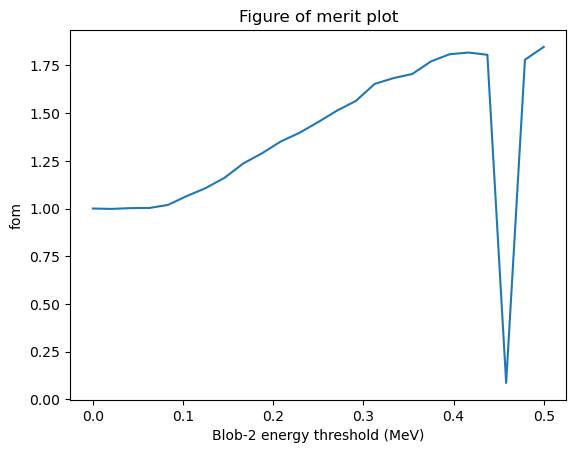

In [82]:
# kill the nans due to poor fitting 
print(fom)
fom = np.array(fom)
fom[np.isnan(fom)] = 0
print(fom)
[print(cut_list)]


# plot fom
plt.plot(cut_list, fom)
plt.title("Figure of merit plot")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

## Graveyard, all old code here

In [64]:
# adding a break in here so when you do 'run all' it stops here
break;

SyntaxError: 'break' outside loop (1414924491.py, line 2)

In [ ]:
# testing fiducial cuts

'''def gth_lth_cuts(df, column_title, one_sided = False, lower_lim = 0, upper_lim = 0, absolute = True):
    #applies cut on column via upper and lower limits (greater than, lesser than)
    #column title for two sided should be a tuple!

    # double sided
    if (one_sided==False):
        # conditional absolute for fiducial case, so include negative values within this range.
        if (absolute == True):
            filt_df = df[(abs(df[column_title[0]]) >= lower_lim) & (abs(df[column_title[1]]) <= upper_lim)]
        else:
            filt_df = df[(df[column_title[0]] >= lower_lim) & (df[column_title[1]] <= upper_lim)]
    # one sided (lower or upper limit)
    else:
        # set greater or lesser based on lower or upper limit being 0
        print("placeholder")
'''
'''
def fiducial_track_cut(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    
    # Bespoke cutting algorithm for NEXT100 isaura which cuts for fiducial volume
    # z is contrained in a two-sided fashion (greater and less than), while R is taken not treated is one-sided.
    
    # create list of events that are outside the fiducial area
    z_df = df[(df['z_min'] <= lower_z) & (df['z_max'] >= upper_z)]
    rz_df = z_df[(z_df['r_max'] >= r_lim)]
    print(rz_df['event'])


    # z filtering
    filt_z_df = df[(df['z_min'] >= lower_z) & (df['z_max'] <= upper_z)] # mm

    # r filtering
    filt_df = filt_z_df[(filt_z_df['r_max'] <= r_lim)]

    # these two create masks, then you need to collect the events to preserve based on this.

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))

    return filt_df
'''


lower_z = 20
upper_z = 1195
r_lim = 472
# create list of events that are outside the fiducial area
z_df_low = tracks[(tracks['z_min'] <= lower_z)]
z_df_up = tracks[(tracks['z_max'] >= upper_z)]
r_df = tracks[(tracks['r_max'] >= r_lim)]
# printing it for understanding
display(z_df_low['event'].to_numpy()[:10])
# the numpy lists of events that need to be removed
df_low_list = (z_df_low['event'].to_numpy())
df_up_list = (z_df_up['event'].to_numpy())
r_list = (r_df['event'].to_numpy())

# then removing all events with these event numbers, lets start with event 112
display(tracks[:103])
# so you can see track 112 has z_min below lower_z
# all rows with event = 112 needs to go here.
remover = tracks[~tracks['event'].isin(df_low_list)]
display(remover[:103]) # does work!

#so lets functionalise this!




#### An aside, looking at the event chains